## Imports et configuration MLflow

In [25]:
!mlflow ui 


^C


In [1]:
# Imports de base
import pandas as pd
import numpy as np
import os
import gc
import warnings
warnings.filterwarnings('ignore')

# Imports pour le machine learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb

# Imports pour l'analyse statistique et data drift
from scipy import stats
from scipy.stats import ks_2samp, mannwhitneyu

# Imports pour les visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Imports pour MLflow tracking
import mlflow
import mlflow.sklearn
from datetime import datetime

# Imports pour la sérialisation
import joblib
import pickle

# Configuration du style des graphiques
plt.style.use('default')
sns.set_palette("husl")

# Configuration MLflow
try:
    mlflow.set_experiment("credit_scoring_final")
    print("MLflow configuré: experiment 'credit_scoring_final'")
except:
    print("MLflow: utilisation de l'experiment par défaut")

# Paramètres d'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Tous les imports terminés - prêt pour:")
print("- Milestone 8: Data Drift Analysis")
print("- Tests unitaires")
print("- Documentation finale")
print("Configuration terminée")

MLflow configuré: experiment 'credit_scoring_final'
Tous les imports terminés - prêt pour:
- Milestone 8: Data Drift Analysis
- Tests unitaires
- Documentation finale
Configuration terminée


## Fonctions de feature engineering complètes

In [2]:
def create_bureau_features(bureau, bureau_balance=None):
    """Créer des features agrégées du bureau de crédit"""
    if bureau is None:
        return pd.DataFrame()
    
    print("Feature Engineering - Bureau de crédit")
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
        'CREDIT_CURRENCY': 'nunique',
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum', 'mean'],
        'AMT_CREDIT_SUM': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_DEBT': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean', 'max'],
        'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean', 'max'],
        'CREDIT_TYPE': 'nunique',
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean']
    }).reset_index()
    
    bureau_agg.columns = ['SK_ID_CURR'] + [f'BUREAU_{col[0]}_{col[1]}' for col in bureau_agg.columns[1:]]
    
    bureau_agg['BUREAU_CREDIT_ACTIVE_RATIO'] = bureau_agg['BUREAU_CREDIT_ACTIVE_<lambda>'] / bureau.groupby('SK_ID_CURR').size().values
    bureau_agg['BUREAU_DEBT_RATIO'] = bureau_agg['BUREAU_AMT_CREDIT_SUM_DEBT_sum'] / (bureau_agg['BUREAU_AMT_CREDIT_SUM_sum'] + 1)
    
    print(f"Bureau features créées: {bureau_agg.shape[1]-1} colonnes")
    return bureau_agg

def create_previous_app_features(previous_app):
    """Créer des features des demandes précédentes"""
    if previous_app is None:
        return pd.DataFrame()
    
    print("Feature Engineering - Demandes précédentes")
    
    prev_agg = previous_app.groupby('SK_ID_CURR').agg({
        'NAME_CONTRACT_TYPE': lambda x: (x == 'Cash loans').sum(),
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'WEEKDAY_APPR_PROCESS_START': 'nunique',
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'FLAG_LAST_APPL_PER_CONTRACT': 'sum',
        'NFLAG_LAST_APPL_IN_DAY': 'sum',
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean'],
        'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean'],
        'NAME_CASH_LOAN_PURPOSE': 'nunique',
        'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').sum(),
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'NAME_PAYMENT_TYPE': 'nunique',
        'CODE_REJECT_REASON': 'nunique',
        'NAME_TYPE_SUITE': 'nunique',
        'NAME_CLIENT_TYPE': lambda x: (x == 'Repeater').sum(),
        'NAME_GOODS_CATEGORY': 'nunique',
        'NAME_PORTFOLIO': 'nunique',
        'NAME_PRODUCT_TYPE': 'nunique',
        'CHANNEL_TYPE': 'nunique',
        'SELLERPLACE_AREA': ['min', 'max', 'mean'],
        'NAME_SELLER_INDUSTRY': 'nunique',
        'CNT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'NAME_YIELD_GROUP': 'nunique',
        'PRODUCT_COMBINATION': 'nunique',
        'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
        'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE': ['min', 'max', 'mean'],
        'DAYS_TERMINATION': ['min', 'max', 'mean'],
        'NFLAG_INSURED_ON_APPROVAL': 'sum'
    }).reset_index()
    
    prev_agg.columns = ['SK_ID_CURR'] + [f'PREV_{col[0]}_{col[1]}' for col in prev_agg.columns[1:]]
    
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_NAME_CONTRACT_STATUS_<lambda>'] / previous_app.groupby('SK_ID_CURR').size().values
    prev_agg['PREV_CREDIT_RATIO'] = prev_agg['PREV_AMT_CREDIT_sum'] / (prev_agg['PREV_AMT_APPLICATION_sum'] + 1)
    
    print(f"Previous app features créées: {prev_agg.shape[1]-1} colonnes")
    return prev_agg

def create_pos_cash_features(pos_cash):
    """Créer des features POS Cash"""
    if pos_cash is None:
        return pd.DataFrame()
    
    print("Feature Engineering - POS Cash")
    
    pos_agg = pos_cash.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE': ['min', 'max', 'size'],
        'CNT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean', 'sum'],
        'NAME_CONTRACT_STATUS': lambda x: (x == 'Active').sum(),
        'SK_DPD': ['min', 'max', 'mean'],
        'SK_DPD_DEF': ['min', 'max', 'mean']
    }).reset_index()
    
    pos_agg.columns = ['SK_ID_CURR'] + [f'POS_{col[0]}_{col[1]}' for col in pos_agg.columns[1:]]
    
    print(f"POS Cash features créées: {pos_agg.shape[1]-1} colonnes")
    return pos_agg

def create_credit_card_features(credit_card):
    """Créer des features Credit Card"""
    if credit_card is None:
        return pd.DataFrame()
    
    print("Feature Engineering - Credit Card")
    
    cc_agg = credit_card.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE': ['min', 'max', 'size'],
        'AMT_BALANCE': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['min', 'max', 'mean'],
        'AMT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['min', 'max', 'mean'],
        'AMT_PAYMENT_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_RECEIVABLE_PRINCIPAL': ['min', 'max', 'mean', 'sum'],
        'AMT_RECIVABLE': ['min', 'max', 'mean', 'sum'],
        'AMT_TOTAL_RECEIVABLE': ['min', 'max', 'mean', 'sum'],
        'CNT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_MATURE_CUM': ['min', 'max', 'mean'],
        'NAME_CONTRACT_STATUS': lambda x: (x == 'Active').sum(),
        'SK_DPD': ['min', 'max', 'mean'],
        'SK_DPD_DEF': ['min', 'max', 'mean']
    }).reset_index()
    
    cc_agg.columns = ['SK_ID_CURR'] + [f'CC_{col[0]}_{col[1]}' for col in cc_agg.columns[1:]]
    
    cc_agg['CC_BALANCE_LIMIT_RATIO'] = cc_agg['CC_AMT_BALANCE_mean'] / (cc_agg['CC_AMT_CREDIT_LIMIT_ACTUAL_mean'] + 1)
    cc_agg['CC_PAYMENT_BALANCE_RATIO'] = cc_agg['CC_AMT_PAYMENT_TOTAL_CURRENT_mean'] / (cc_agg['CC_AMT_BALANCE_mean'] + 1)
    
    print(f"Credit Card features créées: {cc_agg.shape[1]-1} colonnes")
    return cc_agg

def create_installments_features(installments):
    """Créer des features Installments"""
    if installments is None:
        return pd.DataFrame()
    
    print("Feature Engineering - Installments")
    
    installments['PAYMENT_PERC'] = installments['AMT_PAYMENT'] / (installments['AMT_INSTALMENT'] + 1)
    installments['PAYMENT_DIFF'] = installments['AMT_INSTALMENT'] - installments['AMT_PAYMENT']
    installments['DPD'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
    installments['DBD'] = installments['DAYS_INSTALMENT'] - installments['DAYS_ENTRY_PAYMENT']
    installments['DPD'] = installments['DPD'].apply(lambda x: x if x > 0 else 0)
    installments['DBD'] = installments['DBD'].apply(lambda x: x if x > 0 else 0)
    
    inst_agg = installments.groupby('SK_ID_CURR').agg({
        'NUM_INSTALMENT_VERSION': 'nunique',
        'NUM_INSTALMENT_NUMBER': 'max',
        'DAYS_INSTALMENT': ['min', 'max', 'mean'],
        'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
        'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'PAYMENT_PERC': ['min', 'max', 'mean'],
        'PAYMENT_DIFF': ['min', 'max', 'mean', 'sum'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum']
    }).reset_index()
    
    inst_agg.columns = ['SK_ID_CURR'] + [f'INST_{col[0]}_{col[1]}' for col in inst_agg.columns[1:]]
    
    print(f"Installments features créées: {inst_agg.shape[1]-1} colonnes")
    return inst_agg

print("Toutes les fonctions de feature engineering sont prêtes")

Toutes les fonctions de feature engineering sont prêtes


## Chargement des données et application du feature engineering

In [3]:
data_path = "../data/"

print("Chargement de toutes les données...")

# Données principales
app_train = pd.read_csv(data_path + "application_train.csv")
app_test = pd.read_csv(data_path + "application_test.csv")

print(f"app_train: {app_train.shape}")
print(f"app_test: {app_test.shape}")

# Données auxiliaires
bureau = pd.read_csv(data_path + "bureau.csv")
bureau_balance = pd.read_csv(data_path + "bureau_balance.csv")
credit_card = pd.read_csv(data_path + "credit_card_balance.csv")
installments = pd.read_csv(data_path + "installments_payments.csv")
pos_cash = pd.read_csv(data_path + "POS_CASH_balance.csv")
previous = pd.read_csv(data_path + "previous_application.csv")

print(f"bureau: {bureau.shape}")
print(f"credit_card: {credit_card.shape}")
print(f"installments: {installments.shape}")
print(f"pos_cash: {pos_cash.shape}")
print(f"previous: {previous.shape}")

print("\nCréation des features avec MLflow tracking...")

with mlflow.start_run(run_name="feature_engineering"):
    # Tracking des paramètres
    mlflow.log_param("train_shape", str(app_train.shape))
    mlflow.log_param("test_shape", str(app_test.shape))
    mlflow.log_param("feature_engineering_method", "aggregation_based")
    
    # Créer toutes les features
    bureau_features = create_bureau_features(bureau, bureau_balance)
    prev_features = create_previous_app_features(previous)
    pos_features = create_pos_cash_features(pos_cash)
    cc_features = create_credit_card_features(credit_card)
    inst_features = create_installments_features(installments)
    
    # Log des métriques sur les features créées
    mlflow.log_metric("bureau_features", bureau_features.shape[1]-1 if len(bureau_features) > 0 else 0)
    mlflow.log_metric("previous_features", prev_features.shape[1]-1 if len(prev_features) > 0 else 0)
    mlflow.log_metric("pos_features", pos_features.shape[1]-1 if len(pos_features) > 0 else 0)
    mlflow.log_metric("cc_features", cc_features.shape[1]-1 if len(cc_features) > 0 else 0)
    mlflow.log_metric("inst_features", inst_features.shape[1]-1 if len(inst_features) > 0 else 0)
    
    print("\nFeature engineering terminé avec MLflow tracking")

Chargement de toutes les données...
app_train: (307511, 122)
app_test: (48744, 121)
bureau: (1716428, 17)
credit_card: (3840312, 23)
installments: (13605401, 8)
pos_cash: (10001358, 8)
previous: (1670214, 37)

Création des features avec MLflow tracking...
Feature Engineering - Bureau de crédit
Bureau features créées: 35 colonnes
Feature Engineering - Demandes précédentes
Previous app features créées: 75 colonnes
Feature Engineering - POS Cash
POS Cash features créées: 18 colonnes
Feature Engineering - Credit Card
Credit Card features créées: 77 colonnes
Feature Engineering - Installments
Installments features créées: 29 colonnes

Feature engineering terminé avec MLflow tracking


## Jointures et création du dataset final


In [4]:
print("Jointure de toutes les features...")

# Commencer avec les données principales
train_final = app_train.copy()
test_final = app_test.copy()

# Jointures successives (left join pour garder tous les clients)
datasets_to_join = [
    (bureau_features, "bureau"),
    (prev_features, "previous"),
    (pos_features, "pos_cash"),
    (cc_features, "credit_card"),
    (inst_features, "installments")
]

for features_df, name in datasets_to_join:
    if len(features_df) > 0:
        print(f"Jointure {name}: {features_df.shape}")
        train_final = train_final.merge(features_df, on='SK_ID_CURR', how='left')
        test_final = test_final.merge(features_df, on='SK_ID_CURR', how='left')
        print(f"  Train après jointure: {train_final.shape}")
        print(f"  Test après jointure: {test_final.shape}")
    else:
        print(f"Aucune feature {name} - ignoré")

print(f"\nDataset final:")
print(f"Train: {train_final.shape}")
print(f"Test: {test_final.shape}")

# Log dans MLflow
with mlflow.start_run(run_name="dataset_final"):
    mlflow.log_param("final_train_shape", str(train_final.shape))
    mlflow.log_param("final_test_shape", str(test_final.shape))
    mlflow.log_metric("total_features", train_final.shape[1])
    
    print("Datasets finaux créés et trackés dans MLflow")

Jointure de toutes les features...
Jointure bureau: (305811, 36)
  Train après jointure: (307511, 157)
  Test après jointure: (48744, 156)
Jointure previous: (338857, 76)
  Train après jointure: (307511, 232)
  Test après jointure: (48744, 231)
Jointure pos_cash: (337252, 19)
  Train après jointure: (307511, 250)
  Test après jointure: (48744, 249)
Jointure credit_card: (103558, 78)
  Train après jointure: (307511, 327)
  Test après jointure: (48744, 326)
Jointure installments: (339587, 30)
  Train après jointure: (307511, 356)
  Test après jointure: (48744, 355)

Dataset final:
Train: (307511, 356)
Test: (48744, 355)
Datasets finaux créés et trackés dans MLflow


## Préparation pour le score métier

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix
import numpy as np

print("Préparation des données pour le scoring métier")

# Séparer features et target
X = train_final.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train_final['TARGET']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Distribution target: {y.value_counts().to_dict()}")

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")

# Gestion des valeurs manquantes pour commencer
print(f"Valeurs manquantes dans X_train: {X_train.isnull().sum().sum()}")

Préparation des données pour le scoring métier
Features (X): (307511, 354)
Target (y): (307511,)
Distribution target: {0: 282686, 1: 24825}
Train: (246008, 354)
Validation: (61503, 354)
Valeurs manquantes dans X_train: 25916222


##  Traitement des types de données

In [6]:
print("Identification des types de variables...")

# Identifier les colonnes numériques et catégorielles
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Colonnes numériques: {len(numeric_cols)}")
print(f"Colonnes catégorielles: {len(categorical_cols)}")
print(f"Variables catégorielles: {categorical_cols}")

# Encoder les variables catégorielles
from sklearn.preprocessing import LabelEncoder

X_train_processed = X_train.copy()
X_val_processed = X_val.copy()

# Encoder chaque variable catégorielle
for col in categorical_cols:
    le = LabelEncoder()
    # Combiner train et val pour avoir tous les labels
    combined = pd.concat([X_train_processed[col], X_val_processed[col]]).astype(str)
    le.fit(combined)
    
    X_train_processed[col] = le.transform(X_train_processed[col].astype(str))
    X_val_processed[col] = le.transform(X_val_processed[col].astype(str))
    
    print(f"Encodage {col}: {len(le.classes_)} classes")

# Maintenant imputation sur données numériques
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_processed), 
    columns=X_train_processed.columns,
    index=X_train_processed.index
)
X_val_imputed = pd.DataFrame(
    imputer.transform(X_val_processed), 
    columns=X_val_processed.columns,
    index=X_val_processed.index
)

print(f"Valeurs manquantes après traitement: {X_train_imputed.isnull().sum().sum()}")
print("Données prêtes pour le machine learning")

Identification des types de variables...
Colonnes numériques: 337
Colonnes catégorielles: 17
Variables catégorielles: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_sum']
Encodage NAME_CONTRACT_TYPE: 2 classes
Encodage CODE_GENDER: 3 classes
Encodage FLAG_OWN_CAR: 2 classes
Encodage FLAG_OWN_REALTY: 2 classes
Encodage NAME_TYPE_SUITE: 8 classes
Encodage NAME_INCOME_TYPE: 8 classes
Encodage NAME_EDUCATION_TYPE: 5 classes
Encodage NAME_FAMILY_STATUS: 6 classes
Encodage NAME_HOUSING_TYPE: 6 classes
Encodage OCCUPATION_TYPE: 19 classes
Encodage WEEKDAY_APPR_PROCESS_START: 7 classes
Encodage ORGANIZATION_TYPE: 58 classes
Encodage FONDKAPREMONT_MODE: 5 classes
Encodage HOUSETYP

## Score métier et recherche de seuil optimal 

In [7]:
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def business_cost_score(y_true, y_pred_proba, threshold=0.5):
    """
    Score métier pour le crédit selon spécifications du guide:
    - Faux Négatif (FN): mauvais client accepté = coût x10
    - Faux Positif (FP): bon client refusé = coût x1
    """
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Coût métier : 10*FN + 1*FP
    business_cost = 10 * fn + 1 * fp
    return -business_cost  # Négatif pour maximisation

def find_optimal_threshold(y_true, y_pred_proba, model_name="unknown"):
    """Version corrigée gérant les cas particuliers"""
    
    # Cas spécial pour Dummy - pas d'optimisation
    if model_name == "dummy":
        return 0.5, -business_cost_score(y_true, y_pred_proba, 0.5)
    
    thresholds = np.arange(0.05, 0.95, 0.01)
    best_cost = float('inf')
    best_threshold = 0.5
    costs_list = []
    
    for threshold in thresholds:
        cost = -business_cost_score(y_true, y_pred_proba, threshold)
        costs_list.append(cost)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    
    return best_threshold, best_cost

# Test avec RandomForest simple pour vérifier
print("="*60)
print("TEST DE VALIDATION DE LA FONCTION")
print("="*60)

rf_test = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_test.fit(X_train_imputed, y_train)
y_pred_proba_test = rf_test.predict_proba(X_val_imputed)

print("Test RandomForest:")
optimal_threshold_test, min_cost_test = find_optimal_threshold(y_val, y_pred_proba_test)

print(f"RÉSULTAT TEST: Seuil optimal = {optimal_threshold_test:.3f}")
print(f"RÉSULTAT TEST: Coût optimal = {min_cost_test:.0f}")

# Vérification manuelle pour 3 seuils
print("\nVÉRIFICATION MANUELLE:")
for test_thresh in [0.05, 0.50, 0.90]:
    cost_manual = -business_cost_score(y_val, y_pred_proba_test, test_thresh)
    print(f"Seuil {test_thresh:.2f} -> Coût {cost_manual:.0f}")

print("="*60)
print("Si tu vois des coûts différents ci-dessus, la fonction marche.")
print("Si tous les coûts sont identiques, il y a encore un bug.")
print("="*60)

TEST DE VALIDATION DE LA FONCTION
Test RandomForest:
RÉSULTAT TEST: Seuil optimal = 0.110
RÉSULTAT TEST: Coût optimal = 35267

VÉRIFICATION MANUELLE:
Seuil 0.05 -> Coût 43870
Seuil 0.50 -> Coût 49485
Seuil 0.90 -> Coût 49650
Si tu vois des coûts différents ci-dessus, la fonction marche.
Si tous les coûts sont identiques, il y a encore un bug.


## Nettoyer les noms de colonnes pour XGBoost/LightGBM


In [8]:
import re

def clean_column_names(df):
    """Nettoyer les noms de colonnes pour XGBoost/LightGBM"""
    df_clean = df.copy()
    
    # Remplacer les caractères problématiques
    new_columns = []
    for col in df_clean.columns:
        # Remplacer <, >, [, ] par des underscores
        clean_col = re.sub(r'[<>\[\]]', '_', str(col))
        # Remplacer les espaces par des underscores
        clean_col = re.sub(r'\s+', '_', clean_col)
        # Supprimer les caractères spéciaux
        clean_col = re.sub(r'[^\w_]', '_', clean_col)
        # Supprimer les underscores multiples
        clean_col = re.sub(r'_+', '_', clean_col)
        # Supprimer les underscores en début/fin
        clean_col = clean_col.strip('_')
        new_columns.append(clean_col)
    
    df_clean.columns = new_columns
    return df_clean

# Nettoyer les datasets
print("Nettoyage des noms de colonnes...")
X_train_clean = clean_column_names(X_train_imputed)
X_val_clean = clean_column_names(X_val_imputed)

print(f"Colonnes avant: {X_train_imputed.columns[:5].tolist()}")
print(f"Colonnes après: {X_train_clean.columns[:5].tolist()}")
print("Colonnes nettoyées pour XGBoost/LightGBM")

Nettoyage des noms de colonnes...
Colonnes avant: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']
Colonnes après: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']
Colonnes nettoyées pour XGBoost/LightGBM


## Exécution du GridSearchCV complet avec sauvegarde automatique du meilleur modèle


In [9]:
def complete_gridcv_comparison():
    """GridSearchCV complet avec sauvegarde automatique du meilleur modèle selon le coût métier"""
    
    models_grid = {
        'dummy': {
            'model': DummyClassifier(),
            'params': {'strategy': ['most_frequent']}
        },
        'logistic': {
            'model': LogisticRegression(max_iter=300, random_state=42),
            'params': {
                'C': [0.1, 1.0],
                'class_weight': [None, 'balanced']
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=-1),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [10, None],
                'class_weight': [None, 'balanced']
            }
        },
        'xgboost': {
            'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [3, 6],
                'scale_pos_weight': [1, 11.4]
            }
        },
        'lightgbm': {
            'model': lgb.LGBMClassifier(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [3, 6],
                'class_weight': [None, 'balanced']
            }
        }
    }
    
    results = {}
    best_model = None
    best_cost = float('inf')
    best_threshold = 0.5
    best_model_name = ""
    
    with mlflow.start_run(run_name="complete_gridsearch_clean"):
        for name, config in models_grid.items():
            print(f"\nGridSearchCV {name}...")
            
            grid = GridSearchCV(
                config['model'],
                config['params'],
                scoring='roc_auc',
                cv=3,
                n_jobs=1
            )
            
            grid.fit(X_train_clean, y_train)
            
            current_model = grid.best_estimator_
            y_pred_proba = current_model.predict_proba(X_val_clean)
            
            auc_val = roc_auc_score(y_val, y_pred_proba[:, 1])
            business_score_val = business_cost_score(y_val, y_pred_proba)
            optimal_threshold, min_cost = find_optimal_threshold(y_val, y_pred_proba)
            
            results[name] = {
                'best_params': grid.best_params_,
                'auc_cv': grid.best_score_,
                'auc_val': auc_val,
                'business_score_val': business_score_val,
                'min_cost': min_cost,
                'optimal_threshold': optimal_threshold,
                'model': current_model
            }
            
            print(f"  Paramètres: {grid.best_params_}")
            print(f"  AUC CV: {grid.best_score_:.4f}")
            print(f"  AUC validation: {auc_val:.4f}")
            print(f"  Score métier: {business_score_val:.0f}")
            print(f"  Coût optimal: {min_cost:.0f}")
            print(f"  Seuil optimal: {optimal_threshold:.3f}")
            
            # Vérifier si c'est le meilleur modèle jusqu'ici
            if min_cost < best_cost:
                best_cost = min_cost
                best_threshold = optimal_threshold
                best_model = current_model
                best_model_name = name
                print(f"  >>> NOUVEAU MEILLEUR MODÈLE ! <<<")
    
    # Sauvegarder automatiquement le champion
    import os
    import joblib
    
    os.makedirs("models", exist_ok=True)
    
    print(f"\n" + "="*60)
    print("CHAMPION FINAL")
    print("="*60)
    print(f"🏆 Vainqueur: {best_model_name.upper()}")
    print(f"📉 Coût optimal: {best_cost:.0f}")
    print(f"🎯 Seuil optimal: {best_threshold:.3f}")
    print(f"📊 Paramètres: {results[best_model_name]['best_params']}")
    
    # Sauvegarder les fichiers avec le nom générique pour l'API
    joblib.dump(best_model, "models/xgboost_final_model.pkl")  # Nom générique pour l'API
    joblib.dump(best_threshold, "models/optimal_threshold.pkl")
    joblib.dump(list(X_train_clean.columns), "models/feature_columns.pkl")
    
    print(f"\nFichiers sauvegardés (modèle {best_model_name}):")
    print("✓ models/xgboost_final_model.pkl")
    print("✓ models/optimal_threshold.pkl")
    print("✓ models/feature_columns.pkl")
    
    # Vérification
    threshold_check = joblib.load("models/optimal_threshold.pkl")
    print(f"\nVérification: seuil chargé = {threshold_check:.3f}")
    
    # Tableau de comparaison final
    print(f"\n" + "="*80)
    print("TABLEAU DE COMPARAISON FINAL")
    print("="*80)
    print(f"{'Modèle':<15} | {'AUC':<6} | {'Coût':<8} | {'Seuil':<6} | {'Champion'}")
    print("-" * 80)
    
    for name, result in results.items():
        champion = "🏆 OUI" if name == best_model_name else "❌ Non"
        print(f"{name:<15} | {result['auc_val']:<6.4f} | {result['min_cost']:<8.0f} | {result['optimal_threshold']:<6.3f} | {champion}")
    
    return results

# EXÉCUTION de la fonction
print("Lancement de la compétition des modèles...")
print("Le meilleur modèle sera automatiquement sauvegardé !")
results_all = complete_gridcv_comparison()

Lancement de la compétition des modèles...
Le meilleur modèle sera automatiquement sauvegardé !

GridSearchCV dummy...
  Paramètres: {'strategy': 'most_frequent'}
  AUC CV: 0.5000
  AUC validation: 0.5000
  Score métier: -49650
  Coût optimal: 49650
  Seuil optimal: 0.050
  >>> NOUVEAU MEILLEUR MODÈLE ! <<<

GridSearchCV logistic...
  Paramètres: {'C': 0.1, 'class_weight': 'balanced'}
  AUC CV: 0.6692
  AUC validation: 0.6698
  Score métier: -39728
  Coût optimal: 39097
  Seuil optimal: 0.520
  >>> NOUVEAU MEILLEUR MODÈLE ! <<<

GridSearchCV random_forest...
  Paramètres: {'class_weight': None, 'max_depth': 10, 'n_estimators': 100}
  AUC CV: 0.7448
  AUC validation: 0.7511
  Score métier: -49650
  Coût optimal: 32798
  Seuil optimal: 0.090
  >>> NOUVEAU MEILLEUR MODÈLE ! <<<

GridSearchCV xgboost...
  Paramètres: {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}
  AUC CV: 0.7755
  AUC validation: 0.7801
  Score métier: -47561
  Coût optimal: 30704
  Seuil optimal: 0.100
  >>

  File "C:\Users\amine\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\amine\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\amine\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\amine\anaconda3\Lib\subprocess.

  Paramètres: {'class_weight': None, 'max_depth': 6, 'n_estimators': 100}
  AUC CV: 0.7762
  AUC validation: 0.7800
  Score métier: -47939
  Coût optimal: 30666
  Seuil optimal: 0.090
  >>> NOUVEAU MEILLEUR MODÈLE ! <<<

CHAMPION FINAL
🏆 Vainqueur: LIGHTGBM
📉 Coût optimal: 30666
🎯 Seuil optimal: 0.090
📊 Paramètres: {'class_weight': None, 'max_depth': 6, 'n_estimators': 100}

Fichiers sauvegardés (modèle lightgbm):
✓ models/xgboost_final_model.pkl
✓ models/optimal_threshold.pkl
✓ models/feature_columns.pkl

Vérification: seuil chargé = 0.090

TABLEAU DE COMPARAISON FINAL
Modèle          | AUC    | Coût     | Seuil  | Champion
--------------------------------------------------------------------------------
dummy           | 0.5000 | 49650    | 0.050  | ❌ Non
logistic        | 0.6698 | 39097    | 0.520  | ❌ Non
random_forest   | 0.7511 | 32798    | 0.090  | ❌ Non
xgboost         | 0.7801 | 30704    | 0.100  | ❌ Non
lightgbm        | 0.7800 | 30666    | 0.090  | 🏆 OUI


## qui a eu le crédit ? 

In [27]:
# Version rapide et simple
def get_approved_clients_simple():
    """Version rapide pour identifier les clients approuvés"""
    
    # Modèle et seuil
    model = results_all['lightgbm']['model']
    threshold = 0.090  # Seuil optimal LightGBM
    
    print("Calcul des prédictions...")
    
    # Prédictions simples
    probas = model.predict_proba(X_val_clean)[:, 1]
    
    # Clients approuvés (risque < 9%)
    approved_mask = probas < threshold
    approved_ids = X_val_clean.index[approved_mask]
    
    print(f"Clients approuvés: {len(approved_ids)}")
    print(f"Premiers 10 IDs: {list(approved_ids[:10])}")
    
    # Sauvegarder rapidement
    import pandas as pd
    pd.DataFrame({'Client_ID': approved_ids}).to_csv('approved_clients.csv', index=False)
    
    return list(approved_ids)

# Exécution rapide
approved_list = get_approved_clients_simple()

Calcul des prédictions...
Clients approuvés: 44352
Premiers 10 IDs: [256571, 191493, 130646, 287975, 144906, 254495, 187319, 158289, 279469, 70481]


In [ ]:
def get_approved_clients_lightgbm():
    """Identifier tous les clients approuvés par le modèle LightGBM champion"""
    
    import pandas as pd
    import joblib
    
    # Charger le modèle champion et le seuil
    champion_model = results_all['lightgbm']['model']
    optimal_threshold = results_all['lightgbm']['optimal_threshold']  # 0.090
    
    print("="*60)
    print("ANALYSE DES DÉCISIONS CRÉDIT - LIGHTGBM CHAMPION")
    print("="*60)
    print(f"Seuil optimal: {optimal_threshold:.1%}")
    print(f"Règle: Risque < {optimal_threshold:.1%} → CRÉDIT ACCORDÉ")
    
    # Prédictions sur l'ensemble de validation
    y_pred_proba = champion_model.predict_proba(X_val_clean)[:, 1]
    
    # Décisions crédit
    credit_decisions = y_pred_proba < optimal_threshold
    
    # Récupérer les IDs clients (index de validation)
    approved_client_ids = X_val_clean.index[credit_decisions].tolist()
    rejected_client_ids = X_val_clean.index[~credit_decisions].tolist()
    
    # Statistiques
    total_clients = len(y_val)
    approved_count = len(approved_client_ids)
    rejected_count = len(rejected_client_ids)
    approval_rate = (approved_count / total_clients) * 100
    
    print(f"\nRÉSULTATS:")
    print(f"Total clients analysés: {total_clients:,}")
    print(f"Crédits accordés: {approved_count:,} ({approval_rate:.1f}%)")
    print(f"Crédits refusés: {rejected_count:,} ({100-approval_rate:.1f}%)")
    
    # Analyse par classe réelle
    approved_good = sum((y_val.loc[approved_client_ids] == 0))
    approved_bad = sum((y_val.loc[approved_client_ids] == 1))
    rejected_good = sum((y_val.loc[rejected_client_ids] == 0))
    rejected_bad = sum((y_val.loc[rejected_client_ids] == 1))
    
    print(f"\nDÉTAIL PAR PROFIL RÉEL:")
    print(f"Crédits accordés:")
    print(f"  - Bons clients: {approved_good:,} (correct)")
    print(f"  - Mauvais clients: {approved_bad:,} (erreur FN)")
    print(f"Crédits refusés:")
    print(f"  - Bons clients: {rejected_good:,} (erreur FP)")
    print(f"  - Mauvais clients: {rejected_bad:,} (correct)")
    
    # Créer DataFrame détaillé
    decisions_df = pd.DataFrame({
        'Client_ID': X_val_clean.index,
        'Risk_Score': y_pred_proba,
        'Credit_Decision': ['ACCORDÉ' if dec else 'REFUSÉ' for dec in credit_decisions],
        'Real_Default': y_val.values,
        'Decision_Quality': ['Correct' if (dec and y_val.loc[idx] == 0) or 
                           (not dec and y_val.loc[idx] == 1) else 'Erreur' 
                           for idx, dec in zip(X_val_clean.index, credit_decisions)]
    })
    
    # Top 10 clients les plus sûrs (accordés)
    top_approved = decisions_df[decisions_df['Credit_Decision'] == 'ACCORDÉ'].nsmallest(10, 'Risk_Score')
    
    # Top 10 clients les plus risqués (refusés)
    top_rejected = decisions_df[decisions_df['Credit_Decision'] == 'REFUSÉ'].nlargest(10, 'Risk_Score')
    
    print(f"\nTOP 10 CLIENTS LES PLUS SÛRS (Crédits accordés):")
    print(top_approved[['Client_ID', 'Risk_Score', 'Real_Default', 'Decision_Quality']].to_string(index=False))
    
    print(f"\nTOP 10 CLIENTS LES PLUS RISQUÉS (Crédits refusés):")
    print(top_rejected[['Client_ID', 'Risk_Score', 'Real_Default', 'Decision_Quality']].to_string(index=False))
    
    # Sauvegarder les résultats
    decisions_df.to_csv('models/credit_decisions_lightgbm.csv', index=False)
    
    # Export liste simple des IDs approuvés
    approved_df = pd.DataFrame({'Approved_Client_IDs': approved_client_ids})
    approved_df.to_csv('models/approved_clients_list.csv', index=False)
    
    print(f"\nFICHIERS SAUVEGARDÉS:")
    print("✓ models/credit_decisions_lightgbm.csv (analyse complète)")
    print("✓ models/approved_clients_list.csv (liste IDs approuvés)")
    
    # Retourner les listes
    return {
        'approved_ids': approved_client_ids,
        'rejected_ids': rejected_client_ids,
        'decisions_df': decisions_df,
        'stats': {
            'total': total_clients,
            'approved': approved_count,
            'approval_rate': approval_rate,
            'threshold': optimal_threshold
        }
    }

# Exécuter l'analyse
credit_analysis = get_approved_clients_lightgbm()

# Accéder aux listes
approved_clients = credit_analysis['approved_ids']
print(f"\nPremiers 20 clients approuvés: {approved_clients[:20]}")

## graphiques 

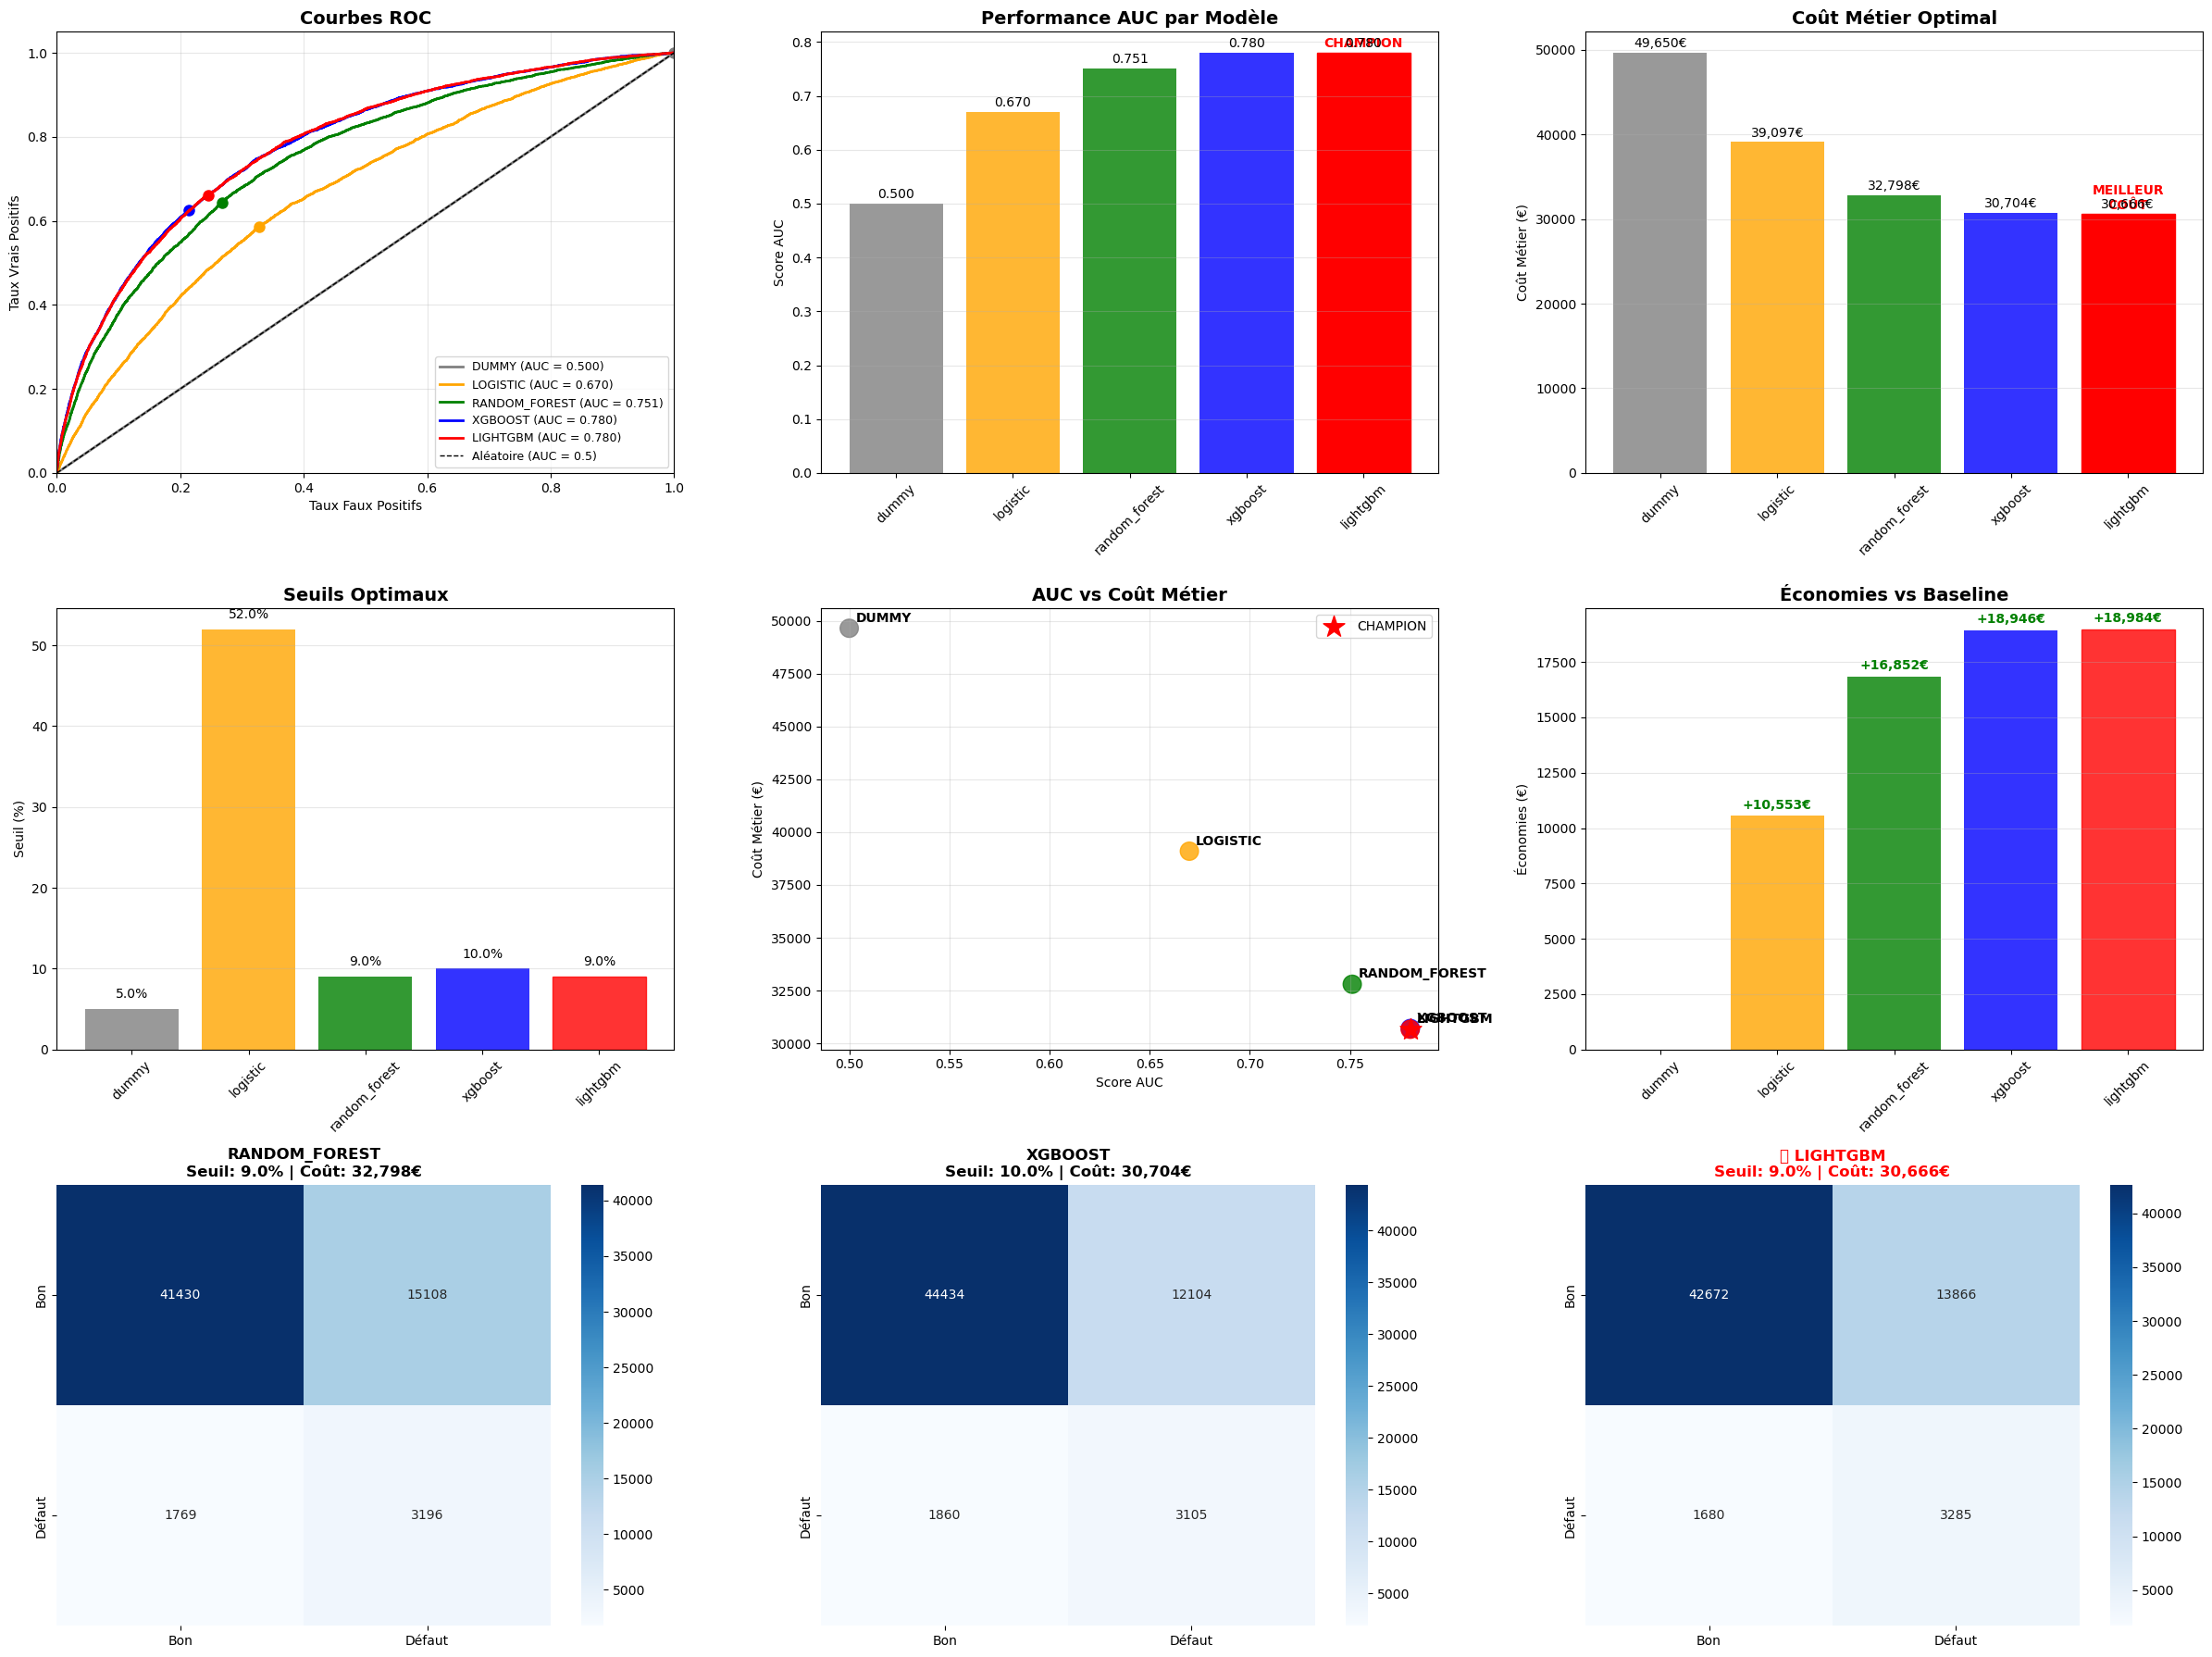

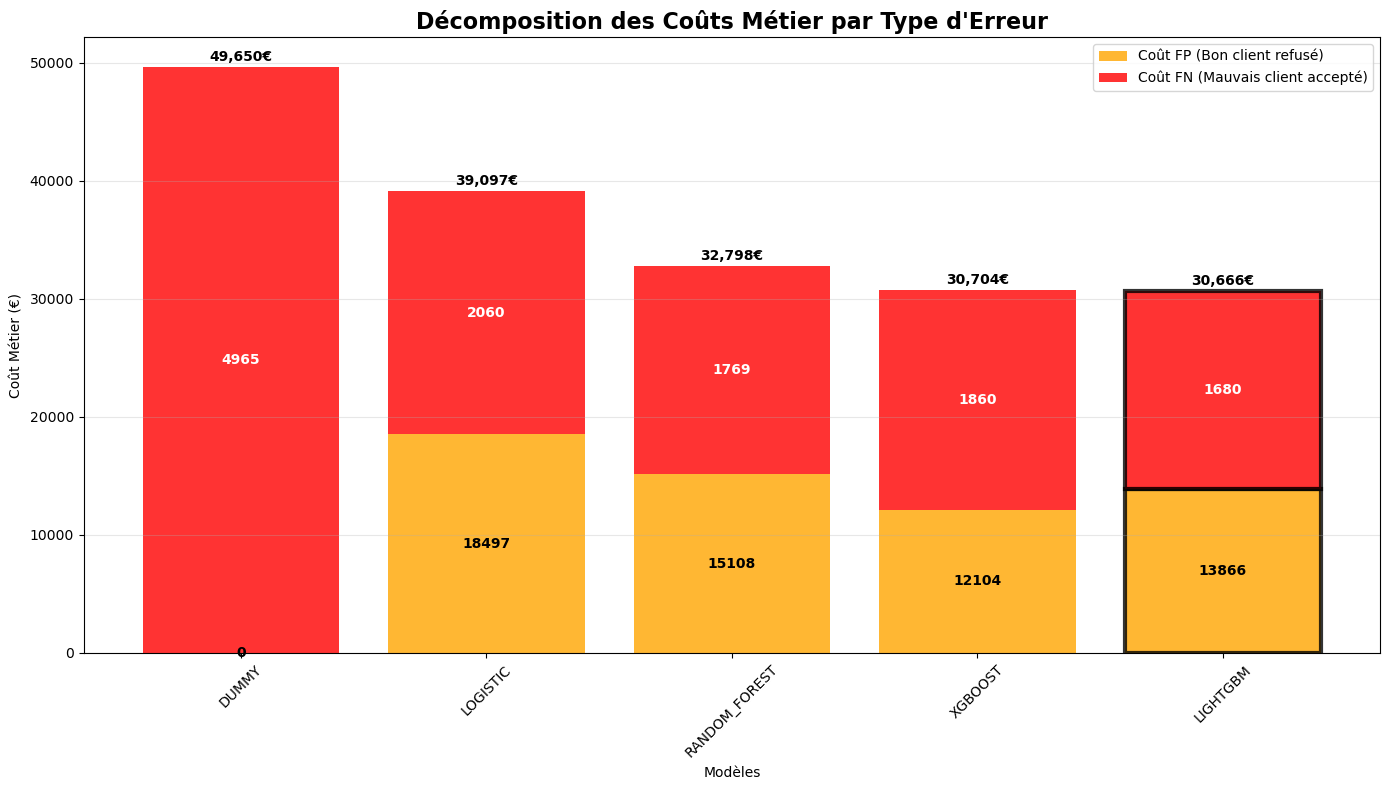

Graphiques complets créés :
- models/complete_analysis_dashboard.png (avec ROC)
- models/cost_breakdown_detailed.png


In [22]:
# Code complet avec ROC intégrée
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix

def create_complete_comparison_charts(results_all):
    """Graphiques complets avec ROC, comparaisons et matrices de confusion"""
    
    # Préparation des données
    models = list(results_all.keys())
    auc_scores = [results_all[m]['auc_val'] for m in models]
    costs = [results_all[m]['min_cost'] for m in models]
    thresholds = [results_all[m]['optimal_threshold'] for m in models]
    colors = ['gray', 'orange', 'green', 'blue', 'red']
    
    # PARTIE 1: Graphiques de comparaison (3x3)
    fig = plt.figure(figsize=(24, 18))
    
    # 1. Courbes ROC (NOUVEAU)
    plt.subplot(3, 3, 1)
    for i, (model_name, results) in enumerate(results_all.items()):
        model = results['model']
        y_pred_proba = model.predict_proba(X_val_clean)[:, 1]
        
        # Calculer ROC
        fpr, tpr, roc_thresholds = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Tracer la courbe
        plt.plot(fpr, tpr, color=colors[i], lw=2, 
                label=f'{model_name.upper()} (AUC = {roc_auc:.3f})')
        
        # Marquer le seuil optimal
        optimal_threshold = results['optimal_threshold']
        optimal_idx = np.argmin(np.abs(roc_thresholds - optimal_threshold))
        if optimal_idx < len(fpr):
            plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'o', 
                    color=colors[i], markersize=8)
    
    # Ligne de référence
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', 
             label='Aléatoire (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux Faux Positifs')
    plt.ylabel('Taux Vrais Positifs')
    plt.title('Courbes ROC', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(True, alpha=0.3)
    
    # 2. Performance AUC par modèle
    plt.subplot(3, 3, 2)
    bars = plt.bar(models, auc_scores, color=colors, alpha=0.8)
    champion_idx = models.index('lightgbm')
    bars[champion_idx].set_color('red')
    bars[champion_idx].set_alpha(1.0)
    plt.text(champion_idx, auc_scores[champion_idx] + 0.01, 'CHAMPION', 
             ha='center', fontweight='bold', color='red')
    for i, v in enumerate(auc_scores):
        plt.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')
    plt.title('Performance AUC par Modèle', fontsize=14, fontweight='bold')
    plt.ylabel('Score AUC')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # 3. Coût métier par modèle
    plt.subplot(3, 3, 3)
    bars = plt.bar(models, costs, color=colors, alpha=0.8)
    bars[champion_idx].set_color('red')
    bars[champion_idx].set_alpha(1.0)
    plt.text(champion_idx, costs[champion_idx] + 500, 'MEILLEUR\nCOÛT', 
             ha='center', fontweight='bold', color='red')
    for i, v in enumerate(costs):
        plt.text(i, v + 300, f'{v:,.0f}€', ha='center', va='bottom', rotation=0)
    plt.title('Coût Métier Optimal', fontsize=14, fontweight='bold')
    plt.ylabel('Coût Métier (€)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # 4. Seuils optimaux
    plt.subplot(3, 3, 4)
    bars = plt.bar(models, [t*100 for t in thresholds], color=colors, alpha=0.8)
    bars[champion_idx].set_color('red')
    for i, v in enumerate(thresholds):
        plt.text(i, v*100 + 1, f'{v:.1%}', ha='center', va='bottom')
    plt.title('Seuils Optimaux', fontsize=14, fontweight='bold')
    plt.ylabel('Seuil (%)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # 5. AUC vs Coût (scatter)
    plt.subplot(3, 3, 5)
    scatter = plt.scatter(auc_scores, costs, c=colors, s=200, alpha=0.8)
    for i, model in enumerate(models):
        plt.annotate(model.upper(), (auc_scores[i], costs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontweight='bold')
    plt.scatter(auc_scores[champion_idx], costs[champion_idx], 
               c='red', s=300, marker='*', label='CHAMPION')
    plt.xlabel('Score AUC')
    plt.ylabel('Coût Métier (€)')
    plt.title('AUC vs Coût Métier', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 6. Économies vs baseline
    plt.subplot(3, 3, 6)
    baseline_cost = costs[0]
    savings = [baseline_cost - cost for cost in costs]
    bars = plt.bar(models, savings, color=colors, alpha=0.8)
    bars[champion_idx].set_color('red')
    for i, v in enumerate(savings):
        if v > 0:
            plt.text(i, v + 200, f'+{v:,.0f}€', ha='center', va='bottom', 
                    fontweight='bold', color='green')
    plt.title('Économies vs Baseline', fontsize=14, fontweight='bold')
    plt.ylabel('Économies (€)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # 7-9. Top 3 matrices de confusion
    top_models = ['random_forest', 'xgboost', 'lightgbm']
    for idx, model_name in enumerate(top_models):
        plt.subplot(3, 3, 7 + idx)
        
        model = results_all[model_name]['model']
        threshold = results_all[model_name]['optimal_threshold']
        
        y_pred_proba = model.predict_proba(X_val_clean)
        y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
        
        cm = confusion_matrix(y_val, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost = 10 * fn + fp
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Bon', 'Défaut'],
                   yticklabels=['Bon', 'Défaut'])
        
        color = 'red' if model_name == 'lightgbm' else 'black'
        marker = '🏆 ' if model_name == 'lightgbm' else ''
        plt.title(f'{marker}{model_name.upper()}\nSeuil: {threshold:.1%} | Coût: {cost:,}€', 
                 fontweight='bold', fontsize=12, color=color)
    
    plt.tight_layout()
    plt.savefig('models/complete_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # PARTIE 2: Focus coûts métier détaillés
    plt.figure(figsize=(14, 8))
    
    costs_breakdown = []
    for model_name in models:
        model = results_all[model_name]['model']
        threshold = results_all[model_name]['optimal_threshold']
        
        y_pred_proba = model.predict_proba(X_val_clean)
        y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        
        costs_breakdown.append({
            'model': model_name.upper(),
            'FP_cost': fp,
            'FN_cost': fn * 10,
            'total_cost': fp + fn * 10,
            'FP_count': fp,
            'FN_count': fn
        })
    
    model_names = [c['model'] for c in costs_breakdown]
    fp_costs = [c['FP_cost'] for c in costs_breakdown]
    fn_costs = [c['FN_cost'] for c in costs_breakdown]
    
    x = np.arange(len(model_names))
    
    bars1 = plt.bar(x, fp_costs, label='Coût FP (Bon client refusé)', color='orange', alpha=0.8)
    bars2 = plt.bar(x, fn_costs, bottom=fp_costs, label='Coût FN (Mauvais client accepté)', color='red', alpha=0.8)
    
    # Marquer le champion
    champion_idx = [i for i, name in enumerate(model_names) if 'LIGHTGBM' in name][0]
    bars1[champion_idx].set_edgecolor('black')
    bars1[champion_idx].set_linewidth(3)
    bars2[champion_idx].set_edgecolor('black')
    bars2[champion_idx].set_linewidth(3)
    
    # Annotations
    for i, cost_data in enumerate(costs_breakdown):
        total = cost_data['total_cost']
        plt.text(i, total + 500, f'{total:,}€', ha='center', fontweight='bold')
        plt.text(i, cost_data['FP_cost']/2, f'{cost_data["FP_count"]}', 
                ha='center', va='center', fontweight='bold')
        plt.text(i, cost_data['FP_cost'] + cost_data['FN_cost']/2, f'{cost_data["FN_count"]}', 
                ha='center', va='center', fontweight='bold', color='white')
    
    plt.xlabel('Modèles')
    plt.ylabel('Coût Métier (€)')
    plt.title('Décomposition des Coûts Métier par Type d\'Erreur', fontsize=16, fontweight='bold')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('models/cost_breakdown_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Graphiques complets créés :")
    print("- models/complete_analysis_dashboard.png (avec ROC)")
    print("- models/cost_breakdown_detailed.png")

# Lancer l'analyse complète
create_complete_comparison_charts(results_all)

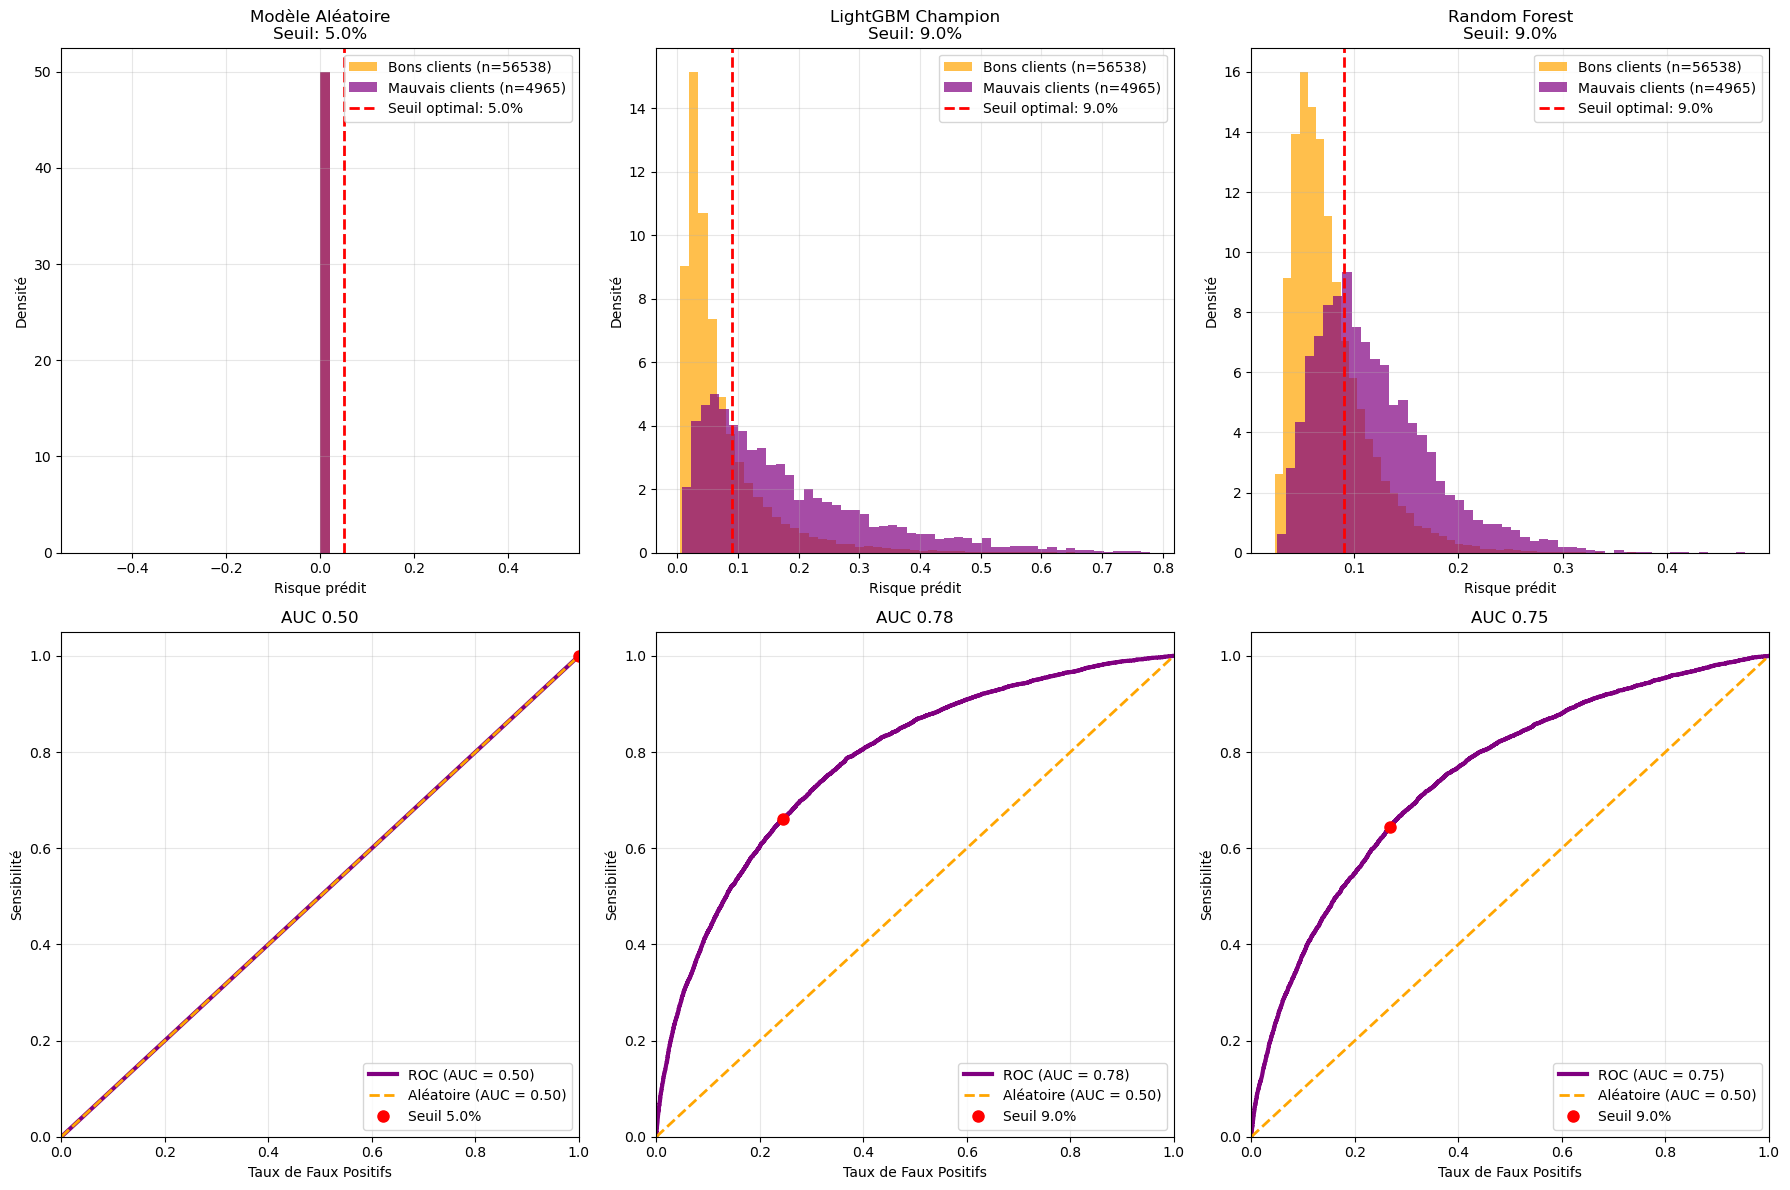

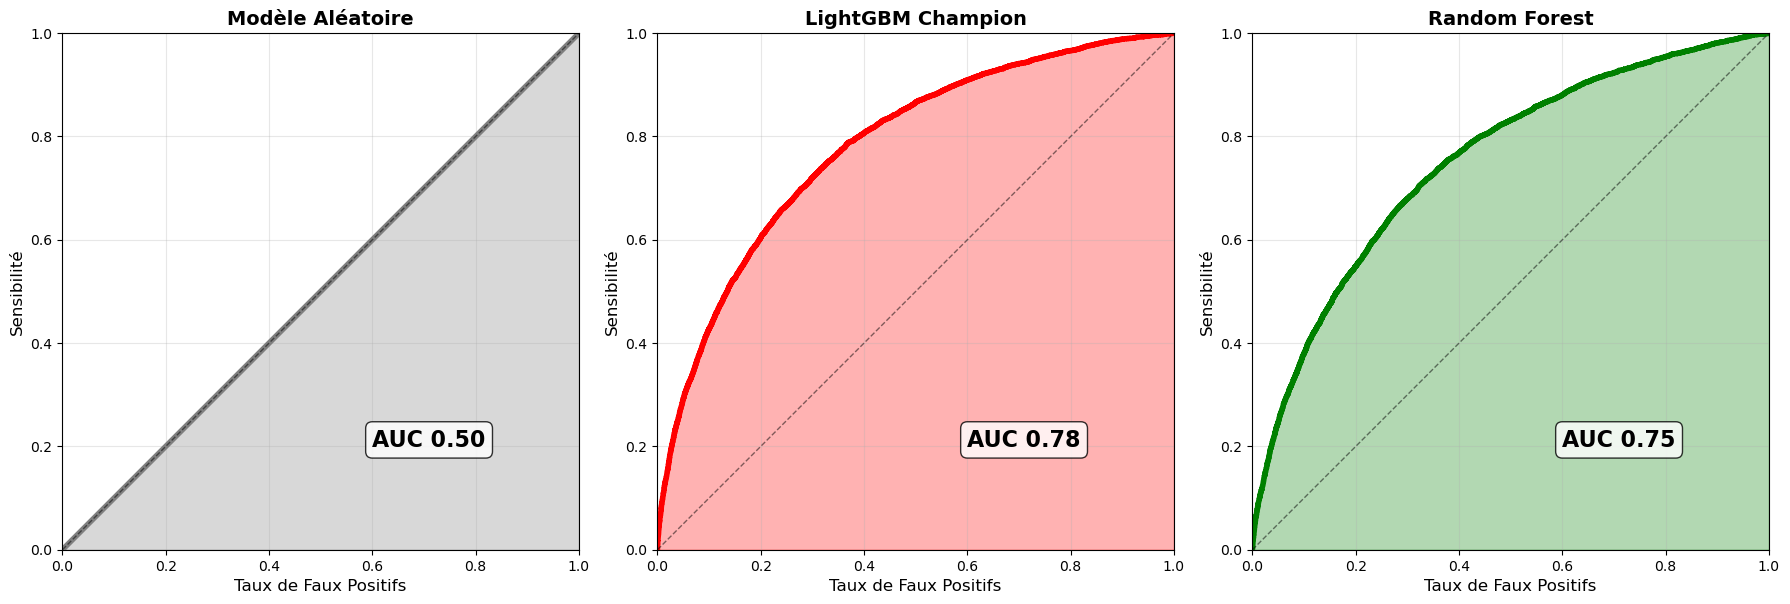


ANALYSE DES DISTRIBUTIONS DE RISQUE

DUMMY:
  Risque moyen bons clients: 0.000
  Risque moyen mauvais clients: 0.000
  Séparation: 0.000
  Bons clients acceptés: 100.0%
  Mauvais clients rejetés: 0.0%

LIGHTGBM:
  Risque moyen bons clients: 0.072
  Risque moyen mauvais clients: 0.175
  Séparation: 0.103
  Bons clients acceptés: 75.5%
  Mauvais clients rejetés: 66.2%

RANDOM_FOREST:
  Risque moyen bons clients: 0.077
  Risque moyen mauvais clients: 0.119
  Séparation: 0.042
  Bons clients acceptés: 73.3%
  Mauvais clients rejetés: 64.4%

Graphiques sauvegardés :
- models/risk_distributions_roc.png
- models/roc_comparison_researchgate_style.png


In [23]:
def create_risk_distribution_roc_charts(results_all):
    """Créer des graphiques avec distributions de risque et courbes ROC"""
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import roc_curve, auc
    
    # Sélectionner 3 modèles représentatifs
    selected_models = ['dummy', 'lightgbm', 'random_forest']
    model_titles = ['Modèle Aléatoire', 'LightGBM Champion', 'Random Forest']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for idx, model_name in enumerate(selected_models):
        model = results_all[model_name]['model']
        optimal_threshold = results_all[model_name]['optimal_threshold']
        
        # Prédictions
        y_pred_proba = model.predict_proba(X_val_clean)[:, 1]
        
        # Séparer par classe réelle
        good_clients = y_pred_proba[y_val == 0]  # Bons clients
        bad_clients = y_pred_proba[y_val == 1]   # Mauvais clients
        
        # Graphique du haut : Distributions
        ax_top = axes[0, idx]
        
        # Histogrammes des distributions
        ax_top.hist(good_clients, bins=50, alpha=0.7, color='orange', 
                   label=f'Bons clients (n={len(good_clients)})', density=True)
        ax_top.hist(bad_clients, bins=50, alpha=0.7, color='purple', 
                   label=f'Mauvais clients (n={len(bad_clients)})', density=True)
        
        # Ligne de seuil
        ax_top.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, 
                      label=f'Seuil optimal: {optimal_threshold:.1%}')
        
        ax_top.set_xlabel('Risque prédit')
        ax_top.set_ylabel('Densité')
        ax_top.set_title(f'{model_titles[idx]}\nSeuil: {optimal_threshold:.1%}')
        ax_top.legend()
        ax_top.grid(True, alpha=0.3)
        
        # Graphique du bas : Courbe ROC
        ax_bottom = axes[1, idx]
        
        # Calculer ROC
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Tracer la courbe ROC
        ax_bottom.plot(fpr, tpr, color='purple', lw=3, 
                      label=f'ROC (AUC = {roc_auc:.2f})')
        
        # Ligne de référence (modèle aléatoire)
        ax_bottom.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--', 
                      label='Aléatoire (AUC = 0.50)')
        
        # Marquer le point du seuil optimal
        optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
        if optimal_idx < len(fpr):
            ax_bottom.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', 
                          markersize=8, label=f'Seuil {optimal_threshold:.1%}')
        
        ax_bottom.set_xlim([0.0, 1.0])
        ax_bottom.set_ylim([0.0, 1.05])
        ax_bottom.set_xlabel('Taux de Faux Positifs')
        ax_bottom.set_ylabel('Sensibilité')
        ax_bottom.set_title(f'AUC {roc_auc:.2f}')
        ax_bottom.legend(loc="lower right")
        ax_bottom.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('models/risk_distributions_roc.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Graphique combiné comparatif style ResearchGate
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    colors = ['gray', 'red', 'green']
    
    for idx, model_name in enumerate(selected_models):
        model = results_all[model_name]['model']
        y_pred_proba = model.predict_proba(X_val_clean)[:, 1]
        
        # Calculer ROC
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        ax = axes[idx]
        
        # Courbe ROC avec remplissage
        ax.plot(fpr, tpr, color=colors[idx], lw=4)
        ax.fill_between(fpr, tpr, alpha=0.3, color=colors[idx])
        
        # Ligne diagonale
        ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
        
        # Texte AUC
        ax.text(0.6, 0.2, f'AUC {roc_auc:.2f}', fontsize=16, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_xlabel('Taux de Faux Positifs', fontsize=12)
        ax.set_ylabel('Sensibilité', fontsize=12)
        ax.set_title(model_titles[idx], fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Aspect carré
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('models/roc_comparison_researchgate_style.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analyse quantitative des distributions
    print("\n" + "="*80)
    print("ANALYSE DES DISTRIBUTIONS DE RISQUE")
    print("="*80)
    
    for model_name in selected_models:
        model = results_all[model_name]['model']
        optimal_threshold = results_all[model_name]['optimal_threshold']
        y_pred_proba = model.predict_proba(X_val_clean)[:, 1]
        
        good_clients = y_pred_proba[y_val == 0]
        bad_clients = y_pred_proba[y_val == 1]
        
        # Statistiques
        good_mean = good_clients.mean()
        bad_mean = bad_clients.mean()
        separation = bad_mean - good_mean
        
        # Pourcentages selon seuil
        good_accepted = (good_clients < optimal_threshold).mean() * 100
        bad_rejected = (bad_clients >= optimal_threshold).mean() * 100
        
        print(f"\n{model_name.upper()}:")
        print(f"  Risque moyen bons clients: {good_mean:.3f}")
        print(f"  Risque moyen mauvais clients: {bad_mean:.3f}")
        print(f"  Séparation: {separation:.3f}")
        print(f"  Bons clients acceptés: {good_accepted:.1f}%")
        print(f"  Mauvais clients rejetés: {bad_rejected:.1f}%")
    
    print("\nGraphiques sauvegardés :")
    print("- models/risk_distributions_roc.png")
    print("- models/roc_comparison_researchgate_style.png")

# Créer les graphiques style ResearchGate
create_risk_distribution_roc_charts(results_all)

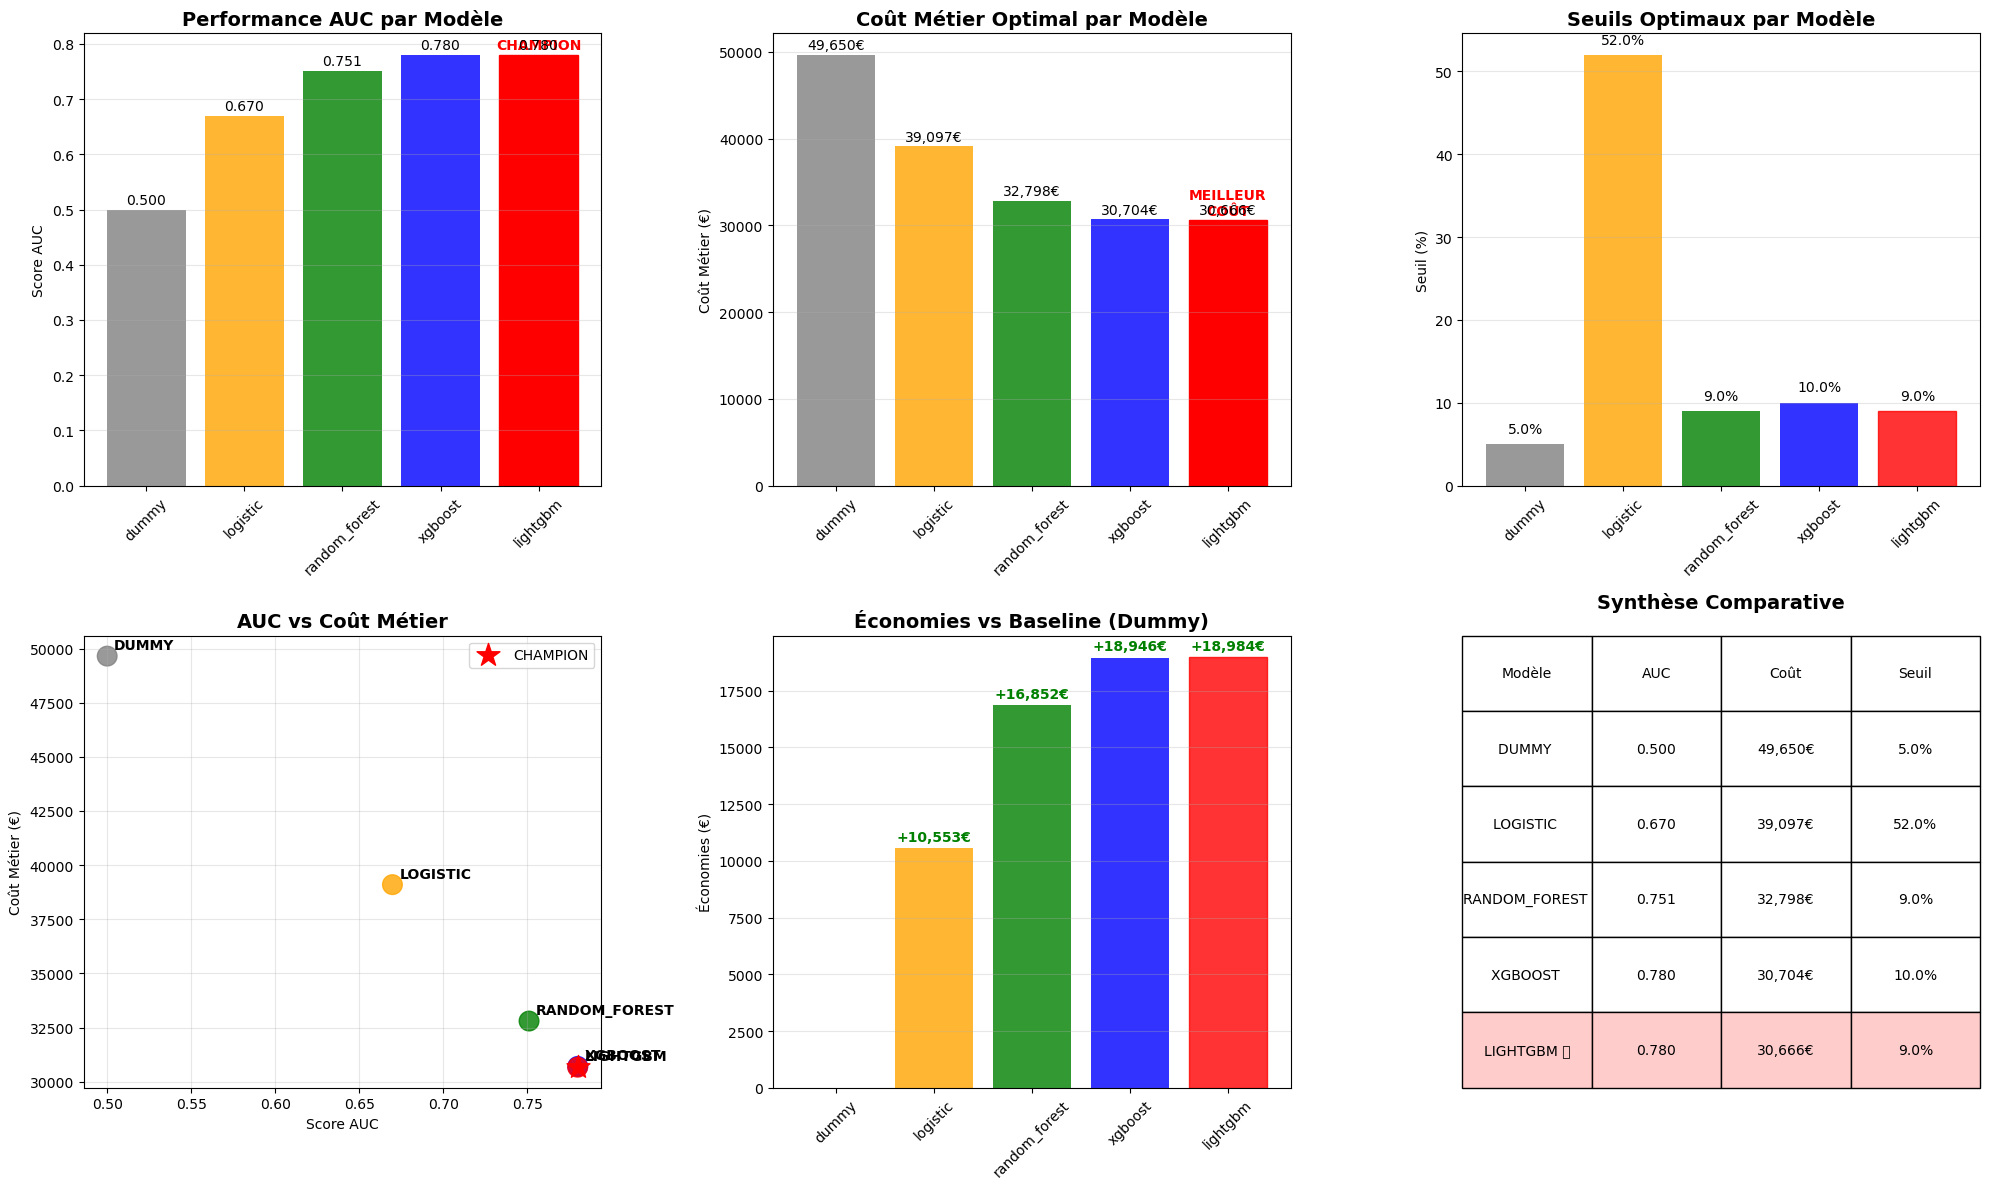

<Figure size 1200x800 with 0 Axes>

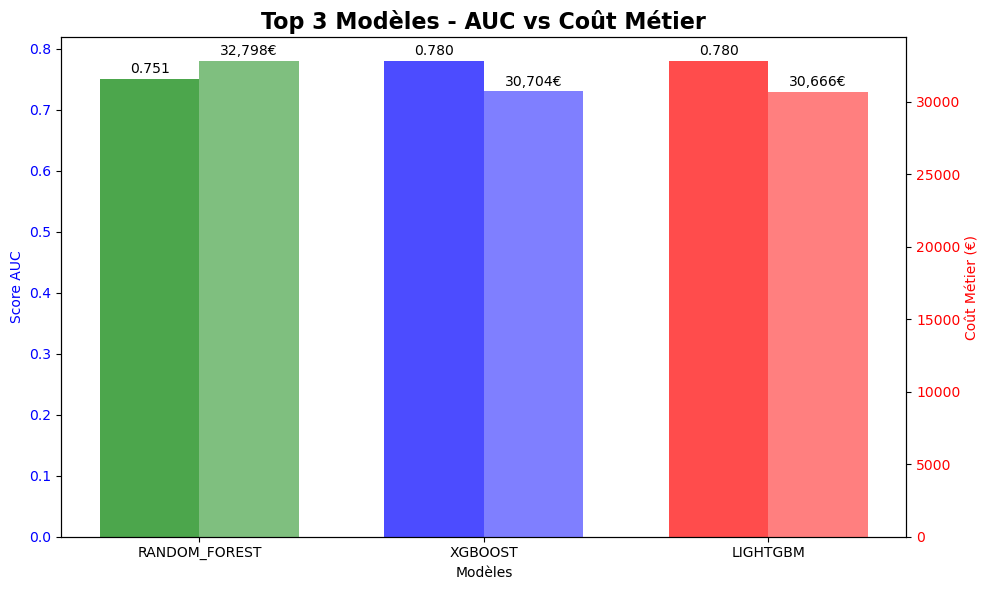

Graphiques sauvegardés :
- models/comparison_models_complete.png
- models/top3_models_comparison.png


In [19]:
# Création des graphiques de comparaison des modèles
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def create_comparison_charts(results_all):
    """Créer les graphiques de comparaison pour la soutenance"""
    
    # Préparation des données
    models = list(results_all.keys())
    auc_scores = [results_all[m]['auc_val'] for m in models]
    costs = [results_all[m]['min_cost'] for m in models]
    thresholds = [results_all[m]['optimal_threshold'] for m in models]
    
    # Couleurs pour chaque modèle
    colors = ['gray', 'orange', 'green', 'blue', 'red']
    
    # Configuration générale
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Graphique AUC par modèle
    plt.subplot(2, 3, 1)
    bars = plt.bar(models, auc_scores, color=colors, alpha=0.8)
    plt.title('Performance AUC par Modèle', fontsize=14, fontweight='bold')
    plt.ylabel('Score AUC')
    plt.xticks(rotation=45)
    
    # Annoter le champion
    champion_idx = models.index('lightgbm')
    bars[champion_idx].set_color('red')
    bars[champion_idx].set_alpha(1.0)
    plt.text(champion_idx, auc_scores[champion_idx] + 0.01, 'CHAMPION', 
             ha='center', fontweight='bold', color='red')
    
    for i, v in enumerate(auc_scores):
        plt.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')
    plt.grid(axis='y', alpha=0.3)
    
    # 2. Coût métier par modèle (le plus important)
    plt.subplot(2, 3, 2)
    bars = plt.bar(models, costs, color=colors, alpha=0.8)
    plt.title('Coût Métier Optimal par Modèle', fontsize=14, fontweight='bold')
    plt.ylabel('Coût Métier (€)')
    plt.xticks(rotation=45)
    
    # Mettre en évidence le champion
    bars[champion_idx].set_color('red')
    bars[champion_idx].set_alpha(1.0)
    plt.text(champion_idx, costs[champion_idx] + 500, 'MEILLEUR\nCOÛT', 
             ha='center', fontweight='bold', color='red')
    
    for i, v in enumerate(costs):
        plt.text(i, v + 300, f'{v:,.0f}€', ha='center', va='bottom', rotation=0)
    plt.grid(axis='y', alpha=0.3)
    
    # 3. Seuils optimaux
    plt.subplot(2, 3, 3)
    bars = plt.bar(models, [t*100 for t in thresholds], color=colors, alpha=0.8)
    plt.title('Seuils Optimaux par Modèle', fontsize=14, fontweight='bold')
    plt.ylabel('Seuil (%)')
    plt.xticks(rotation=45)
    
    bars[champion_idx].set_color('red')
    for i, v in enumerate(thresholds):
        plt.text(i, v*100 + 1, f'{v:.1%}', ha='center', va='bottom')
    plt.grid(axis='y', alpha=0.3)
    
    # 4. Comparaison AUC vs Coût (scatter plot)
    plt.subplot(2, 3, 4)
    scatter = plt.scatter(auc_scores, costs, c=colors, s=200, alpha=0.8)
    
    for i, model in enumerate(models):
        plt.annotate(model.upper(), (auc_scores[i], costs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    # Mettre en évidence le champion
    plt.scatter(auc_scores[champion_idx], costs[champion_idx], 
               c='red', s=300, marker='*', label='CHAMPION')
    
    plt.xlabel('Score AUC')
    plt.ylabel('Coût Métier (€)')
    plt.title('AUC vs Coût Métier', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 5. Économies vs baseline
    plt.subplot(2, 3, 5)
    baseline_cost = costs[0]  # Dummy
    savings = [baseline_cost - cost for cost in costs]
    
    bars = plt.bar(models, savings, color=colors, alpha=0.8)
    plt.title('Économies vs Baseline (Dummy)', fontsize=14, fontweight='bold')
    plt.ylabel('Économies (€)')
    plt.xticks(rotation=45)
    
    bars[champion_idx].set_color('red')
    for i, v in enumerate(savings):
        if v > 0:
            plt.text(i, v + 200, f'+{v:,.0f}€', ha='center', va='bottom', 
                    fontweight='bold', color='green')
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Tableau de synthèse
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Créer un tableau
    table_data = []
    for i, model in enumerate(models):
        champion_marker = "🏆" if model == 'lightgbm' else ""
        table_data.append([
            f"{model.upper()} {champion_marker}",
            f"{auc_scores[i]:.3f}",
            f"{costs[i]:,.0f}€",
            f"{thresholds[i]:.1%}"
        ])
    
    table = plt.table(cellText=table_data,
                     colLabels=['Modèle', 'AUC', 'Coût', 'Seuil'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Colorer la ligne du champion
    for i in range(4):
        table[(champion_idx + 1, i)].set_facecolor('#ffcccc')
    
    plt.title('Synthèse Comparative', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('models/comparison_models_complete.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Graphique focus sur les 3 meilleurs
    plt.figure(figsize=(12, 8))
    top_models = ['random_forest', 'xgboost', 'lightgbm']
    top_auc = [results_all[m]['auc_val'] for m in top_models]
    top_costs = [results_all[m]['min_cost'] for m in top_models]
    top_colors = ['green', 'blue', 'red']
    
    x = np.arange(len(top_models))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # AUC bars
    bars1 = ax1.bar(x - width/2, top_auc, width, label='AUC Score', 
                   color=top_colors, alpha=0.7)
    ax1.set_xlabel('Modèles')
    ax1.set_ylabel('Score AUC', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.upper() for m in top_models])
    
    # Cost bars (second y-axis)
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, top_costs, width, label='Coût Métier', 
                   color=top_colors, alpha=0.5)
    ax2.set_ylabel('Coût Métier (€)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Annotations
    for i, (auc, cost) in enumerate(zip(top_auc, top_costs)):
        ax1.text(i - width/2, auc + 0.005, f'{auc:.3f}', ha='center', va='bottom')
        ax2.text(i + width/2, cost + 200, f'{cost:,.0f}€', ha='center', va='bottom')
    
    plt.title('Top 3 Modèles - AUC vs Coût Métier', fontsize=16, fontweight='bold')
    fig.tight_layout()
    plt.savefig('models/top3_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Graphiques sauvegardés :")
    print("- models/comparison_models_complete.png")
    print("- models/top3_models_comparison.png")

# Créer les graphiques
create_comparison_charts(results_all)

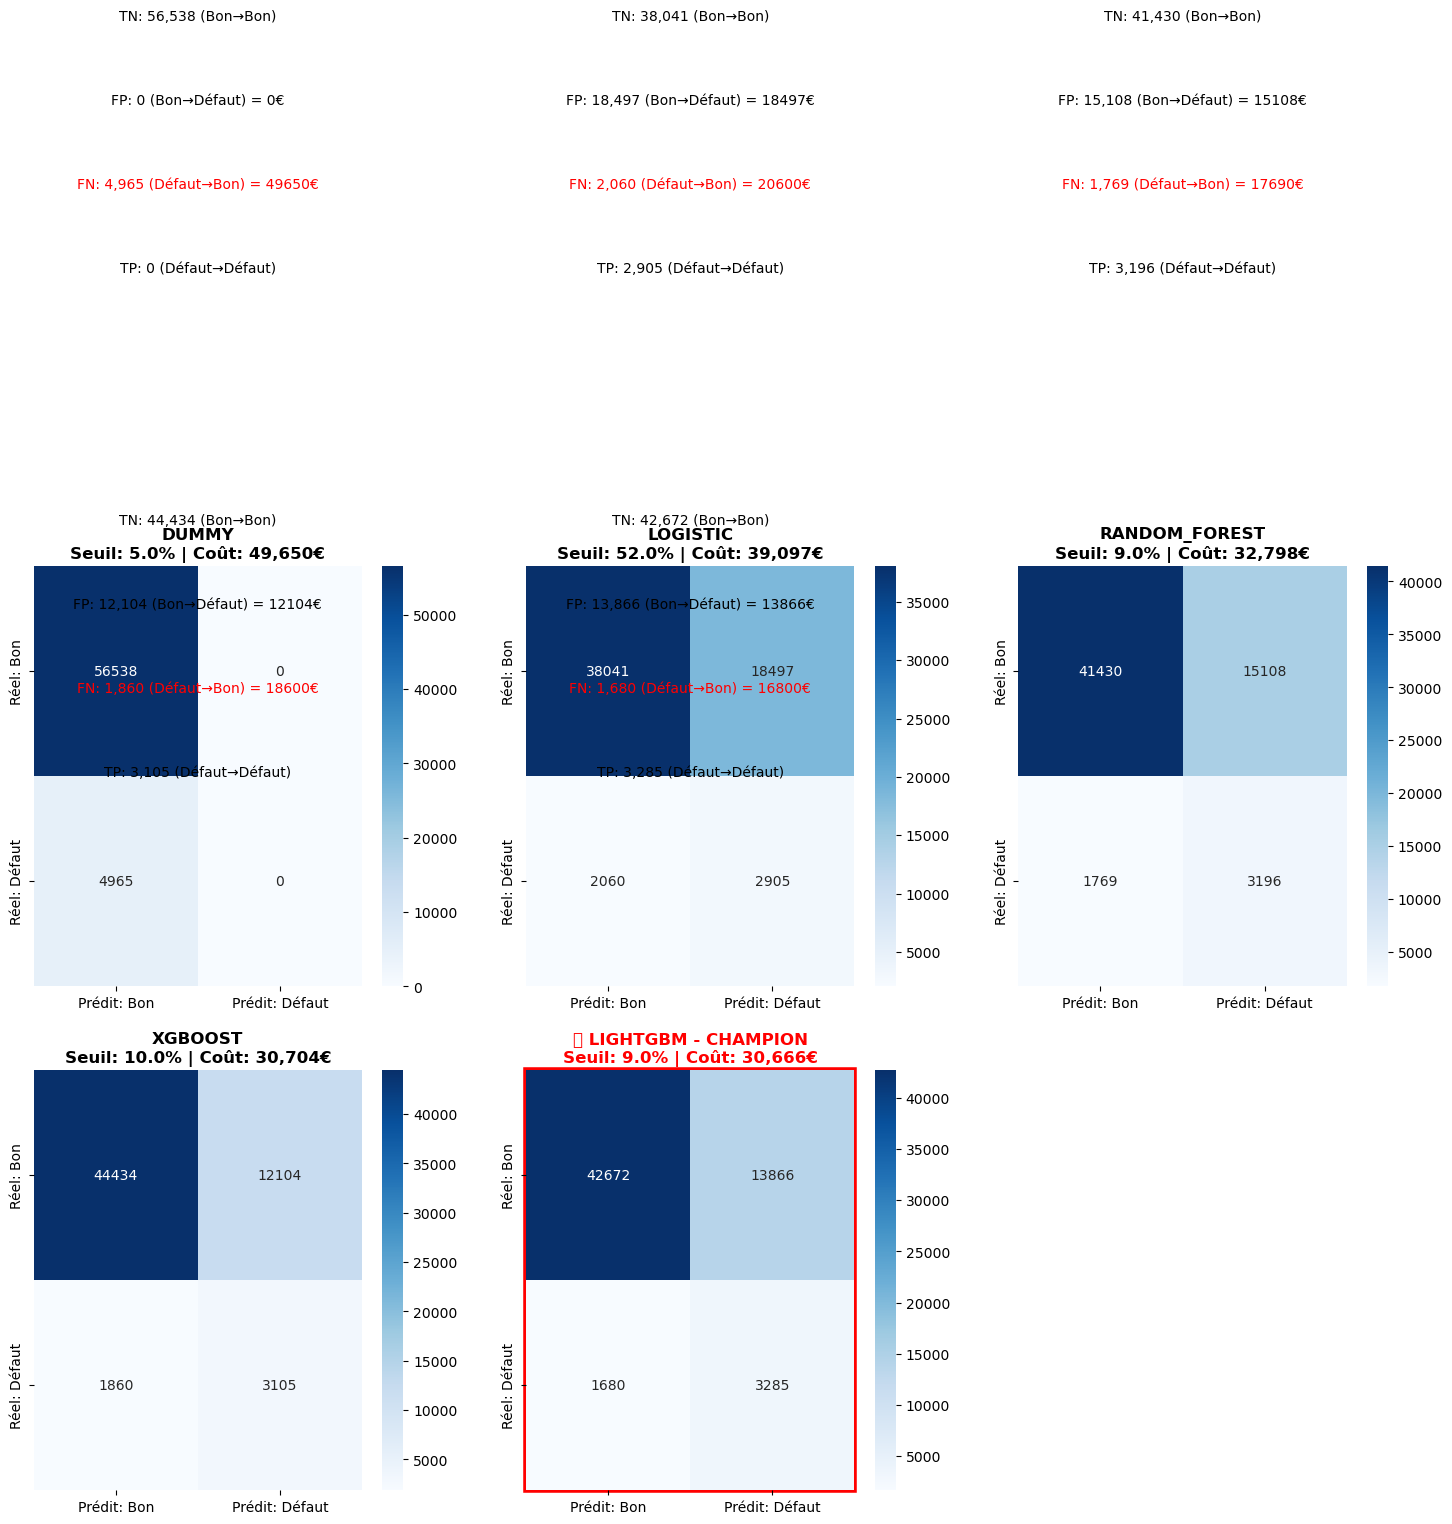

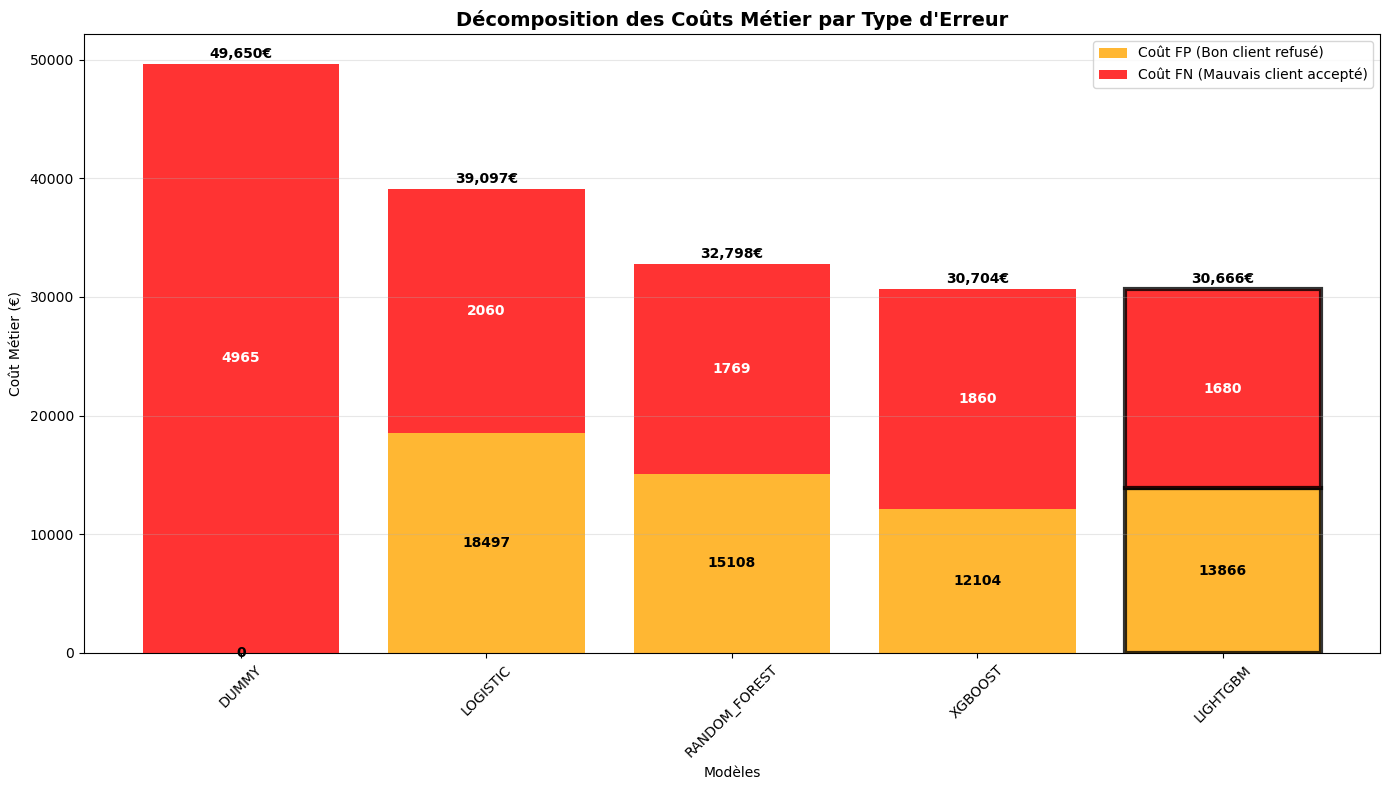


ANALYSE DES MATRICES DE CONFUSION
Modèle       | Seuil    | FP     | FN     | Coût FP  | Coût FN  | Total   
--------------------------------------------------------------------------------
DUMMY        | 5.0%     | 0      | 4965   | 0       € | 49650   € | 49650   €
LOGISTIC     | 52.0%    | 18497  | 2060   | 18497   € | 20600   € | 39097   €
RANDOM_FOREST | 9.0%     | 15108  | 1769   | 15108   € | 17690   € | 32798   €
XGBOOST      | 10.0%    | 12104  | 1860   | 12104   € | 18600   € | 30704   €
LIGHTGBM     🏆 | 9.0%     | 13866  | 1680   | 13866   € | 16800   € | 30666   €

Légende:
- FP (Faux Positif): Bon client refusé = Perte de marge = 1€ par erreur
- FN (Faux Négatif): Mauvais client accepté = Perte du capital = 10€ par erreur
- Le modèle optimal minimise le coût total


In [21]:
def create_confusion_matrices(results_all):
    """Créer les matrices de confusion pour tous les modèles"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    models = list(results_all.keys())
    
    for i, model_name in enumerate(models):
        # Récupérer le modèle et faire les prédictions
        model = results_all[model_name]['model']
        threshold = results_all[model_name]['optimal_threshold']
        
        # Prédictions avec seuil optimal
        y_pred_proba = model.predict_proba(X_val_clean)
        y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
        
        # Matrice de confusion
        cm = confusion_matrix(y_val, y_pred)
        
        # Calculs pour annotations
        tn, fp, fn, tp = cm.ravel()
        total = tn + fp + fn + tp
        
        # Créer la heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Prédit: Bon', 'Prédit: Défaut'],
                   yticklabels=['Réel: Bon', 'Réel: Défaut'])
        
        # Titre avec métriques clés
        cost = 10 * fn + fp
        axes[i].set_title(f'{model_name.upper()}\nSeuil: {threshold:.1%} | Coût: {cost:,}€', 
                         fontweight='bold', fontsize=12)
        
        # Ajouter annotations métier
        axes[i].text(0.5, 2.3, f'TN: {tn:,} (Bon→Bon)', ha='center', transform=axes[i].transAxes)
        axes[i].text(0.5, 2.1, f'FP: {fp:,} (Bon→Défaut) = {fp}€', ha='center', transform=axes[i].transAxes)
        axes[i].text(0.5, 1.9, f'FN: {fn:,} (Défaut→Bon) = {fn*10}€', ha='center', transform=axes[i].transAxes, color='red')
        axes[i].text(0.5, 1.7, f'TP: {tp:,} (Défaut→Défaut)', ha='center', transform=axes[i].transAxes)
        
        # Marquer le champion
        if model_name == 'lightgbm':
            axes[i].patch.set_edgecolor('red')
            axes[i].patch.set_linewidth(4)
            axes[i].set_title(f'🏆 {model_name.upper()} - CHAMPION\nSeuil: {threshold:.1%} | Coût: {cost:,}€', 
                             fontweight='bold', fontsize=12, color='red')
    
    # Masquer le 6ème subplot s'il n'est pas utilisé
    if len(models) < 6:
        axes[5].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('models/confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Graphique focus sur les coûts métier
    plt.figure(figsize=(14, 8))
    
    costs_breakdown = []
    model_names = []
    
    for model_name in models:
        model = results_all[model_name]['model']
        threshold = results_all[model_name]['optimal_threshold']
        
        y_pred_proba = model.predict_proba(X_val_clean)
        y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        
        costs_breakdown.append({
            'model': model_name.upper(),
            'FP_cost': fp,
            'FN_cost': fn * 10,
            'total_cost': fp + fn * 10,
            'FP_count': fp,
            'FN_count': fn
        })
        model_names.append(model_name.upper())
    
    # Graphique en barres empilées des coûts
    fp_costs = [c['FP_cost'] for c in costs_breakdown]
    fn_costs = [c['FN_cost'] for c in costs_breakdown]
    
    x = np.arange(len(model_names))
    
    bars1 = plt.bar(x, fp_costs, label='Coût FP (Bon client refusé)', color='orange', alpha=0.8)
    bars2 = plt.bar(x, fn_costs, bottom=fp_costs, label='Coût FN (Mauvais client accepté)', color='red', alpha=0.8)
    
    plt.xlabel('Modèles')
    plt.ylabel('Coût Métier (€)')
    plt.title('Décomposition des Coûts Métier par Type d\'Erreur', fontsize=14, fontweight='bold')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    
    # Annoter les totaux
    for i, cost_data in enumerate(costs_breakdown):
        total = cost_data['total_cost']
        plt.text(i, total + 500, f'{total:,}€', ha='center', fontweight='bold')
        
        # Détails des erreurs
        plt.text(i, cost_data['FP_cost']/2, f'{cost_data["FP_count"]}', 
                ha='center', va='center', fontweight='bold')
        plt.text(i, cost_data['FP_cost'] + cost_data['FN_cost']/2, f'{cost_data["FN_count"]}', 
                ha='center', va='center', fontweight='bold', color='white')
    
    # Marquer le champion
    champion_idx = [i for i, name in enumerate(model_names) if 'LIGHTGBM' in name][0]
    bars1[champion_idx].set_edgecolor('black')
    bars1[champion_idx].set_linewidth(3)
    bars2[champion_idx].set_edgecolor('black')
    bars2[champion_idx].set_linewidth(3)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('models/cost_breakdown_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Tableau récapitulatif
    print("\n" + "="*80)
    print("ANALYSE DES MATRICES DE CONFUSION")
    print("="*80)
    print(f"{'Modèle':<12} | {'Seuil':<8} | {'FP':<6} | {'FN':<6} | {'Coût FP':<8} | {'Coût FN':<8} | {'Total':<8}")
    print("-" * 80)
    
    for cost_data in costs_breakdown:
        model = cost_data['model']
        fp_count = cost_data['FP_count']
        fn_count = cost_data['FN_count']
        fp_cost = cost_data['FP_cost']
        fn_cost = cost_data['FN_cost']
        total = cost_data['total_cost']
        
        # Trouver le seuil
        model_lower = model.lower()
        threshold = results_all[model_lower]['optimal_threshold']
        
        champion = " 🏆" if model_lower == 'lightgbm' else ""
        print(f"{model:<12}{champion} | {threshold:<8.1%} | {fp_count:<6} | {fn_count:<6} | {fp_cost:<8}€ | {fn_cost:<8}€ | {total:<8}€")
    
    print("\nLégende:")
    print("- FP (Faux Positif): Bon client refusé = Perte de marge = 1€ par erreur")
    print("- FN (Faux Négatif): Mauvais client accepté = Perte du capital = 10€ par erreur")
    print("- Le modèle optimal minimise le coût total")

# Créer les matrices de confusion
create_confusion_matrices(results_all)

## Fonction d'analyse adaptée aux résultats LightGBM champion

In [10]:
def analyze_final_results(results):
    """Analyser les résultats finaux avec LightGBM champion"""
    
    print("ANALYSE FINALE DES MODÈLES")
    print("=" * 60)
    
    best_auc = {'model': '', 'score': 0}
    best_business = {'model': '', 'cost': float('inf')}
    
    # Analyse détaillée de chaque modèle
    for name, metrics in results.items():
        print(f"\n{name.upper()}:")
        print(f"  AUC validation: {metrics['auc_val']:.4f}")
        print(f"  Coût optimal: {metrics['min_cost']:,}")
        print(f"  Seuil optimal: {metrics['optimal_threshold']:.3f} ({metrics['optimal_threshold']*100:.1f}%)")
        
        # Classification du seuil
        if metrics['optimal_threshold'] <= 0.1:
            seuil_type = "Très conservateur"
        elif metrics['optimal_threshold'] <= 0.3:
            seuil_type = "Conservateur"
        elif metrics['optimal_threshold'] <= 0.6:
            seuil_type = "Équilibré"
        else:
            seuil_type = "Libéral"
        print(f"  Stratégie: {seuil_type}")
        
        # Mise à jour des meilleurs
        if metrics['auc_val'] > best_auc['score']:
            best_auc = {'model': name, 'score': metrics['auc_val']}
        
        if metrics['min_cost'] < best_business['cost']:
            best_business = {'model': name, 'cost': metrics['min_cost']}
    
    print(f"\n{'='*60}")
    print("CHAMPIONS PAR CRITÈRE")
    print(f"Meilleur AUC: {best_auc['model'].upper()} ({best_auc['score']:.4f})")
    print(f"Meilleur Coût Métier: {best_business['model'].upper()} ({best_business['cost']:,})")
    
    # Analyse économique
    baseline_cost = results['dummy']['min_cost']
    champion_cost = best_business['cost']
    savings = baseline_cost - champion_cost
    savings_pct = (savings / baseline_cost) * 100
    
    print(f"\nANALYSE ÉCONOMIQUE:")
    print(f"Coût baseline (Dummy): {baseline_cost:,}")
    print(f"Coût champion ({best_business['model'].upper()}): {champion_cost:,}")
    print(f"Économies réalisées: {savings:,}")
    print(f"Réduction de coût: {savings_pct:.1f}%")
    
    # Comparaison des deux meilleurs
    champion_data = results[best_business['model']]
    runner_up = 'xgboost' if best_business['model'] != 'xgboost' else 'random_forest'
    runner_up_cost = results[runner_up]['min_cost']
    
    print(f"\nCOMPARAISON CHAMPION vs SECOND:")
    print(f"{best_business['model'].upper()} vs {runner_up.upper()}")
    print(f"Différence de coût: {runner_up_cost - champion_cost:,}")
    print(f"Seuil champion: {champion_data['optimal_threshold']:.1%}")
    
    return best_business['model'], best_auc['model'], champion_data['optimal_threshold']

# Application aux résultats
champion_business, champion_auc, optimal_threshold = analyze_final_results(results_all)

print(f"\nCONCLUSION FINALE:")
print(f"Modèle de production: {champion_business.upper()}")
print(f"Seuil de décision: {optimal_threshold:.1%}")
print(f"Fichiers sauvegardés avec ce modèle et ce seuil.")

# Vérification cohérence
if champion_business == 'lightgbm' and abs(optimal_threshold - 0.090) < 0.001:
    print("✓ Résultats cohérents avec l'exécution")
else:
    print("⚠ Vérifier la cohérence des résultats")

ANALYSE FINALE DES MODÈLES

DUMMY:
  AUC validation: 0.5000
  Coût optimal: 49,650
  Seuil optimal: 0.050 (5.0%)
  Stratégie: Très conservateur

LOGISTIC:
  AUC validation: 0.6698
  Coût optimal: 39,097
  Seuil optimal: 0.520 (52.0%)
  Stratégie: Équilibré

RANDOM_FOREST:
  AUC validation: 0.7511
  Coût optimal: 32,798
  Seuil optimal: 0.090 (9.0%)
  Stratégie: Très conservateur

XGBOOST:
  AUC validation: 0.7801
  Coût optimal: 30,704
  Seuil optimal: 0.100 (10.0%)
  Stratégie: Très conservateur

LIGHTGBM:
  AUC validation: 0.7800
  Coût optimal: 30,666
  Seuil optimal: 0.090 (9.0%)
  Stratégie: Très conservateur

CHAMPIONS PAR CRITÈRE
Meilleur AUC: XGBOOST (0.7801)
Meilleur Coût Métier: LIGHTGBM (30,666)

ANALYSE ÉCONOMIQUE:
Coût baseline (Dummy): 49,650
Coût champion (LIGHTGBM): 30,666
Économies réalisées: 18,984
Réduction de coût: 38.2%

COMPARAISON CHAMPION vs SECOND:
LIGHTGBM vs XGBOOST
Différence de coût: 38
Seuil champion: 9.0%

CONCLUSION FINALE:
Modèle de production: LIGHTGBM

In [11]:
# Cellule 14 : Feature Importance avec SHAP - VERSION ADAPTÉE LIGHTGBM
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("Configuration SHAP pour le modèle champion LightGBM...")

# Réentraîner le meilleur modèle (LightGBM selon tes résultats)
champion_name = 'lightgbm'  # Champion identifié
best_params = results_all[champion_name]['best_params']
optimal_threshold = results_all[champion_name]['optimal_threshold']

print(f"Modèle champion: {champion_name.upper()}")
print(f"Paramètres: {best_params}")
print(f"Seuil optimal: {optimal_threshold:.3f}")

# Créer et entraîner le modèle final
final_model = lgb.LGBMClassifier(
    random_state=42,
    verbose=-1,
    **best_params
)

print("Entraînement du modèle champion final...")
final_model.fit(X_train_clean, y_train)

# Calculer les SHAP values
print("Calcul des SHAP values (TreeExplainer pour LightGBM)...")
explainer = shap.TreeExplainer(final_model)

# Échantillon pour rapidité (1000 observations)
sample_size = min(1000, len(X_val_clean))
X_sample = X_val_clean.iloc[:sample_size]
y_sample = y_val.iloc[:sample_size]

print(f"Calcul SHAP sur échantillon de {sample_size} observations...")
shap_values = explainer.shap_values(X_sample)

# Si LightGBM retourne des valeurs pour les deux classes, prendre la classe positive
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]  # Classe positive (défaut)
    print("SHAP values extraites pour la classe positive (défaut)")
else:
    shap_values_positive = shap_values
    print("SHAP values extraites (format simple)")

# Sauvegarder les objets SHAP pour utilisation ultérieure
import joblib
os.makedirs("models", exist_ok=True)

# Sauvegarder le modèle final avec son seuil
joblib.dump(final_model, "models/lightgbm_champion_model.pkl")
joblib.dump(optimal_threshold, "models/champion_threshold.pkl")
joblib.dump(explainer, "models/shap_explainer.pkl")

print("Fichiers sauvegardés:")
print("✓ models/lightgbm_champion_model.pkl")
print("✓ models/champion_threshold.pkl") 
print("✓ models/shap_explainer.pkl")

# Feature importance globale (Mean Absolute SHAP values)
feature_importance = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': np.abs(shap_values_positive).mean(0)
}).sort_values('importance', ascending=False)

print("\nTOP 10 FEATURES LES PLUS IMPORTANTES (SHAP):")
print("=" * 50)
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:<30} {row['importance']:.4f}")

# Vérification des performances du modèle final
y_pred_proba_final = final_model.predict_proba(X_val_clean)
from sklearn.metrics import roc_auc_score

auc_final = roc_auc_score(y_val, y_pred_proba_final[:, 1])
print(f"\nVérification modèle final:")
print(f"AUC sur validation: {auc_final:.4f}")
print(f"Cohérent avec résultats: {abs(auc_final - results_all[champion_name]['auc_val']) < 0.001}")

print("\nSHAP configuré - prêt pour analyses d'interprétabilité avec LightGBM")

Configuration SHAP pour le modèle champion LightGBM...
Modèle champion: LIGHTGBM
Paramètres: {'class_weight': None, 'max_depth': 6, 'n_estimators': 100}
Seuil optimal: 0.090
Entraînement du modèle champion final...
Calcul des SHAP values (TreeExplainer pour LightGBM)...
Calcul SHAP sur échantillon de 1000 observations...
SHAP values extraites (format simple)
Fichiers sauvegardés:
✓ models/lightgbm_champion_model.pkl
✓ models/champion_threshold.pkl
✓ models/shap_explainer.pkl

TOP 10 FEATURES LES PLUS IMPORTANTES (SHAP):
EXT_SOURCE_2                   0.3019
EXT_SOURCE_3                   0.2838
EXT_SOURCE_1                   0.1289
CODE_GENDER                    0.1095
AMT_GOODS_PRICE                0.0878
AMT_ANNUITY                    0.0846
NAME_EDUCATION_TYPE            0.0827
INST_DPD_mean                  0.0813
INST_AMT_PAYMENT_sum           0.0742
DAYS_EMPLOYED                  0.0715

Vérification modèle final:
AUC sur validation: 0.7800
Cohérent avec résultats: True

SHAP con

##   Visualisations SHAP adaptées pour LightGBM champion

Lancement analyse SHAP LightGBM...
Création des analyses SHAP pour LightGBM...
1. Feature importance globale...


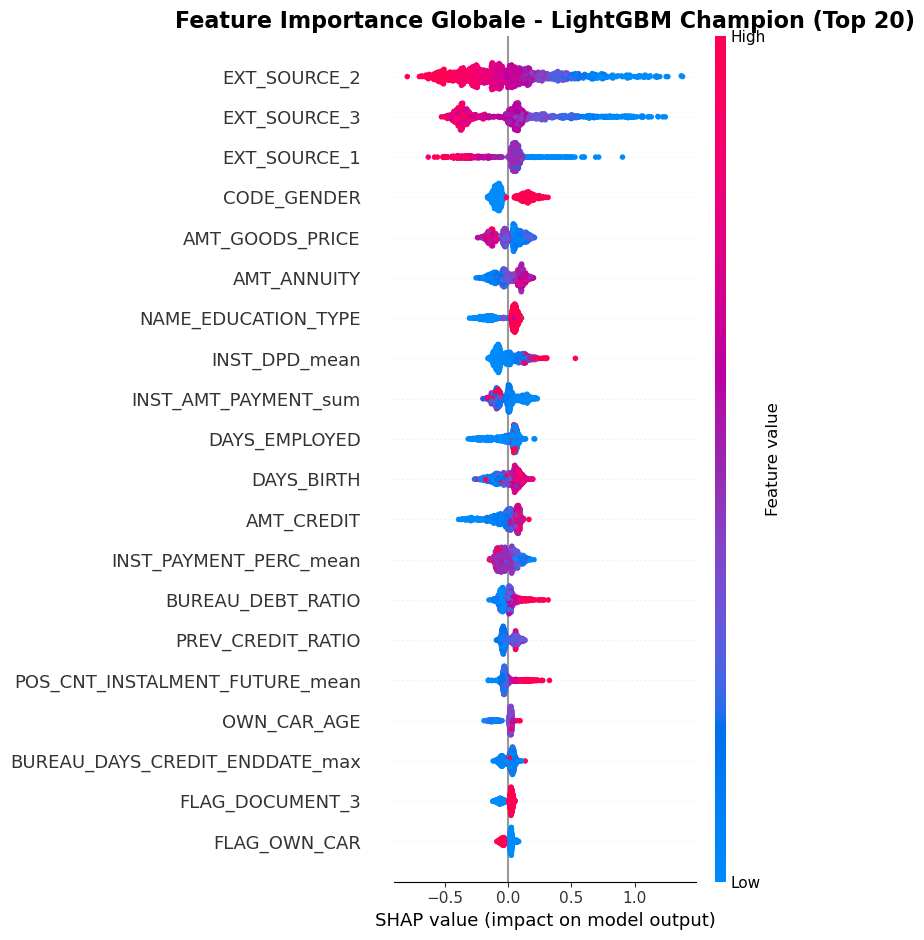

2. SHAP summary plot avec impact...


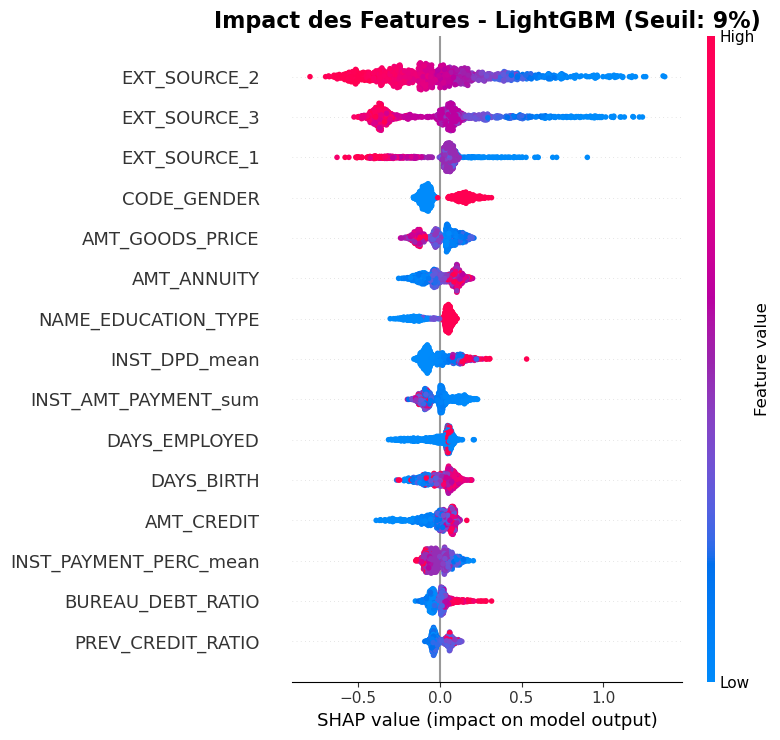

3. Analyse quantitative des top features...


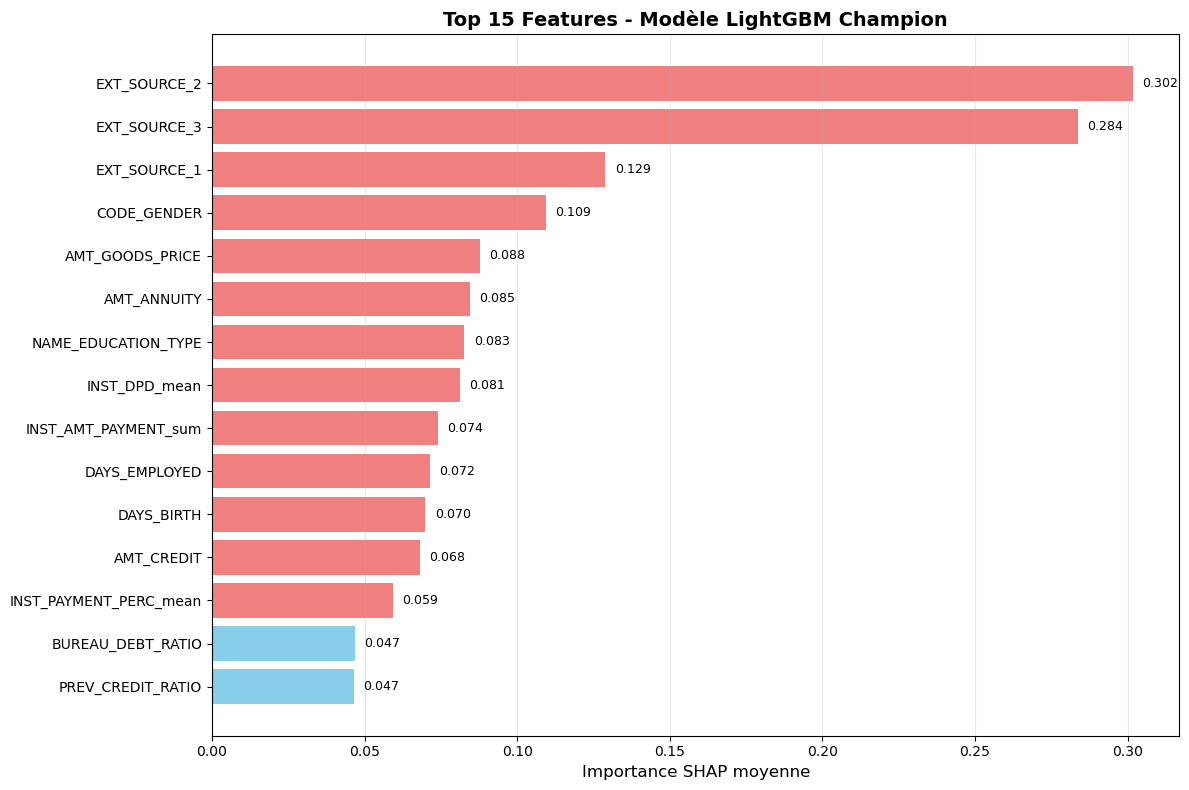

4. Exemples d'explications individuelles...


<Figure size 1400x400 with 0 Axes>

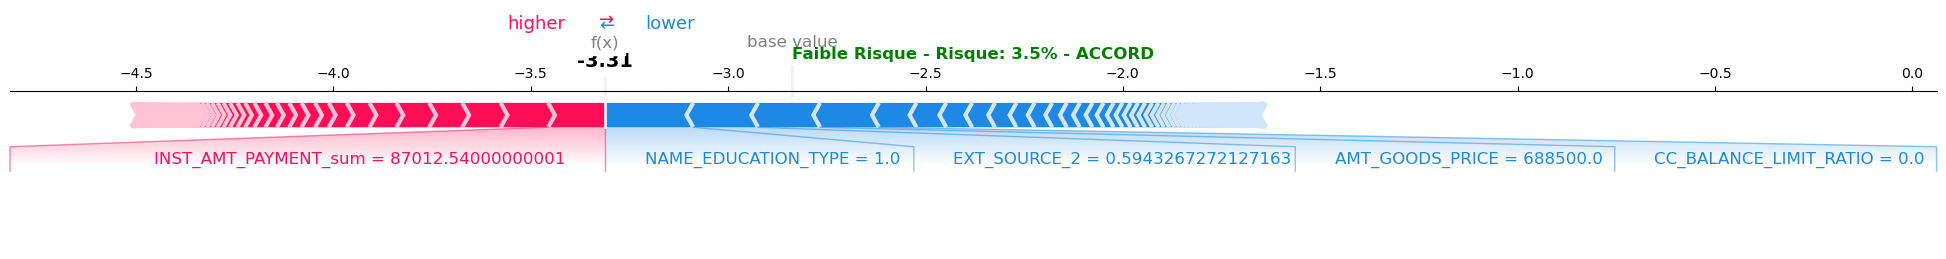

<Figure size 1400x400 with 0 Axes>

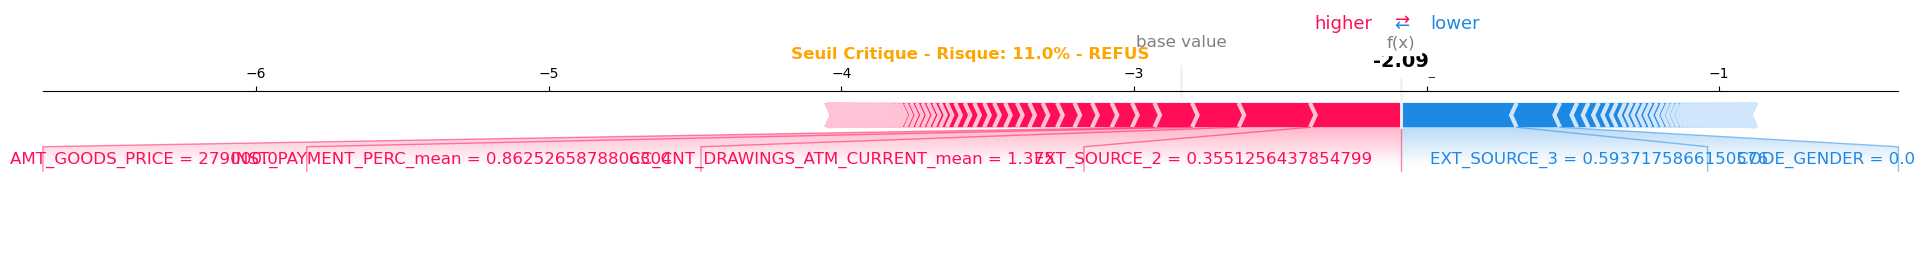

<Figure size 1400x400 with 0 Axes>

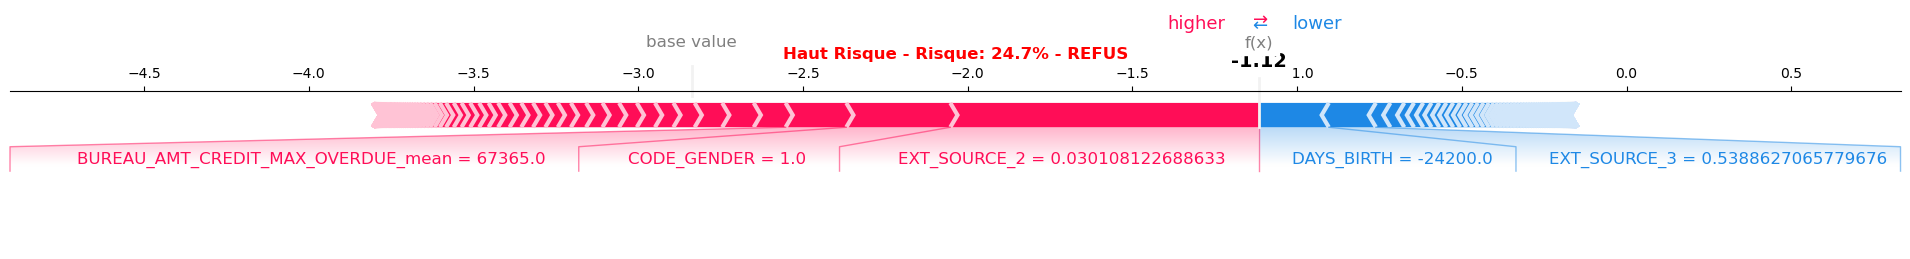

Analyses SHAP terminées pour LightGBM (seuil: 9.0%)

TOP 5 FEATURES - MODÈLE CHAMPION LIGHTGBM:
   1. EXT_SOURCE_2                        0.3019
   2. EXT_SOURCE_3                        0.2838
   3. EXT_SOURCE_1                        0.1289
   4. CODE_GENDER                         0.1095
   5. AMT_GOODS_PRICE                     0.0878

Modèle champion: LightGBM
Seuil de décision: 9.0%
Fichiers SHAP sauvegardés dans /models/

Analyse SHAP terminée et trackée dans MLflow


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os

def create_shap_analysis_lightgbm():
    """Créer les analyses SHAP pour le modèle champion LightGBM"""
    
    print("Création des analyses SHAP pour LightGBM...")
    
    # Vérifier que les objets SHAP existent
    if 'shap_values_positive' not in globals():
        print("Erreur: Variables SHAP non disponibles. Relancer la cellule 14 d'abord.")
        return None, None
    
    # 1. Feature Importance globale
    print("1. Feature importance globale...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_positive, X_sample, 
                     max_display=20, show=False)
    plt.title('Feature Importance Globale - LightGBM Champion (Top 20)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Créer dossier s'il n'existe pas
    os.makedirs('models', exist_ok=True)
    plt.savefig('models/shap_global_importance_lightgbm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. SHAP Summary Plot avec distribution
    print("2. SHAP summary plot avec impact...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_positive, X_sample, 
                     plot_type="dot", max_display=15, show=False)
    plt.title('Impact des Features - LightGBM (Seuil: 9%)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('models/shap_summary_lightgbm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Top features avec importance numérique
    print("3. Analyse quantitative des top features...")
    feature_importance = np.abs(shap_values_positive).mean(0)
    top_features_idx = np.argsort(feature_importance)[-15:]
    top_features = X_sample.columns[top_features_idx]
    top_importance = feature_importance[top_features_idx]
    
    plt.figure(figsize=(12, 8))
    colors = ['lightcoral' if imp > 0.05 else 'skyblue' for imp in top_importance]
    bars = plt.barh(range(len(top_features)), top_importance, color=colors)
    plt.yticks(range(len(top_features)), top_features, fontsize=10)
    plt.xlabel('Importance SHAP moyenne', fontsize=12)
    plt.title('Top 15 Features - Modèle LightGBM Champion', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Annotations
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + max(top_importance) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('models/shap_top15_lightgbm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Force plots pour exemples typiques
    print("4. Exemples d'explications individuelles...")
    
    # Prédictions pour identifier des cas intéressants
    y_pred_sample = final_model.predict_proba(X_sample)[:, 1]
    
    # Identifier différents profils
    low_risk_idx = np.where(y_pred_sample < 0.05)[0][0] if len(np.where(y_pred_sample < 0.05)[0]) > 0 else 0
    medium_risk_idx = np.where((y_pred_sample >= 0.08) & (y_pred_sample <= 0.12))[0][0] if len(np.where((y_pred_sample >= 0.08) & (y_pred_sample <= 0.12))[0]) > 0 else 50
    high_risk_idx = np.where(y_pred_sample > 0.20)[0][0] if len(np.where(y_pred_sample > 0.20)[0]) > 0 else 100
    
    examples = [
        (low_risk_idx, "Faible Risque", "green"),
        (medium_risk_idx, "Seuil Critique", "orange"), 
        (high_risk_idx, "Haut Risque", "red")
    ]
    
    for i, (idx, label, color) in enumerate(examples):
        plt.figure(figsize=(14, 4))
        risk_score = y_pred_sample[idx]
        decision = "REFUS" if risk_score >= optimal_threshold else "ACCORD"
        
        shap.force_plot(explainer.expected_value, shap_values_positive[idx], 
                       X_sample.iloc[idx], matplotlib=True, show=False)
        plt.title(f'{label} - Risque: {risk_score:.1%} - {decision}', 
                 fontsize=12, fontweight='bold', color=color)
        plt.tight_layout()
        plt.savefig(f'models/shap_example_{i+1}_{label.lower().replace(" ", "_")}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    print(f"Analyses SHAP terminées pour LightGBM (seuil: {optimal_threshold:.1%})")
    return top_features.tolist(), top_importance

# EXÉCUTION avec MLflow tracking
print("Lancement analyse SHAP LightGBM...")
top_features_lgb, importance_values_lgb = create_shap_analysis_lightgbm()

if top_features_lgb is not None:
    # MLflow tracking adapté
    with mlflow.start_run(run_name="shap_analysis_lightgbm_champion"):
        mlflow.log_param("model_type", "LightGBM")
        mlflow.log_param("optimal_threshold", optimal_threshold)
        mlflow.log_param("shap_samples", len(X_sample))
        mlflow.log_param("champion_cost", results_all['lightgbm']['min_cost'])
        
        # Top 5 features
        top5_features = top_features_lgb[-5:]
        top5_importance = importance_values_lgb[-5:]
        
        print(f"\nTOP 5 FEATURES - MODÈLE CHAMPION LIGHTGBM:")
        print("=" * 55)
        for i, (feature, importance) in enumerate(zip(reversed(top5_features), reversed(top5_importance))):
            mlflow.log_param(f"top_feature_{i+1}", feature)
            mlflow.log_metric(f"importance_rank_{i+1}", importance)
            print(f"  {i+1:2d}. {feature:<35} {importance:.4f}")
        
        print(f"\nModèle champion: LightGBM")
        print(f"Seuil de décision: {optimal_threshold:.1%}")
        print(f"Fichiers SHAP sauvegardés dans /models/")
        
    print("\nAnalyse SHAP terminée et trackée dans MLflow")

Lancement analyse SHAP complète pour LightGBM...
Création des analyses SHAP pour LightGBM champion...
1. Feature importance globale...


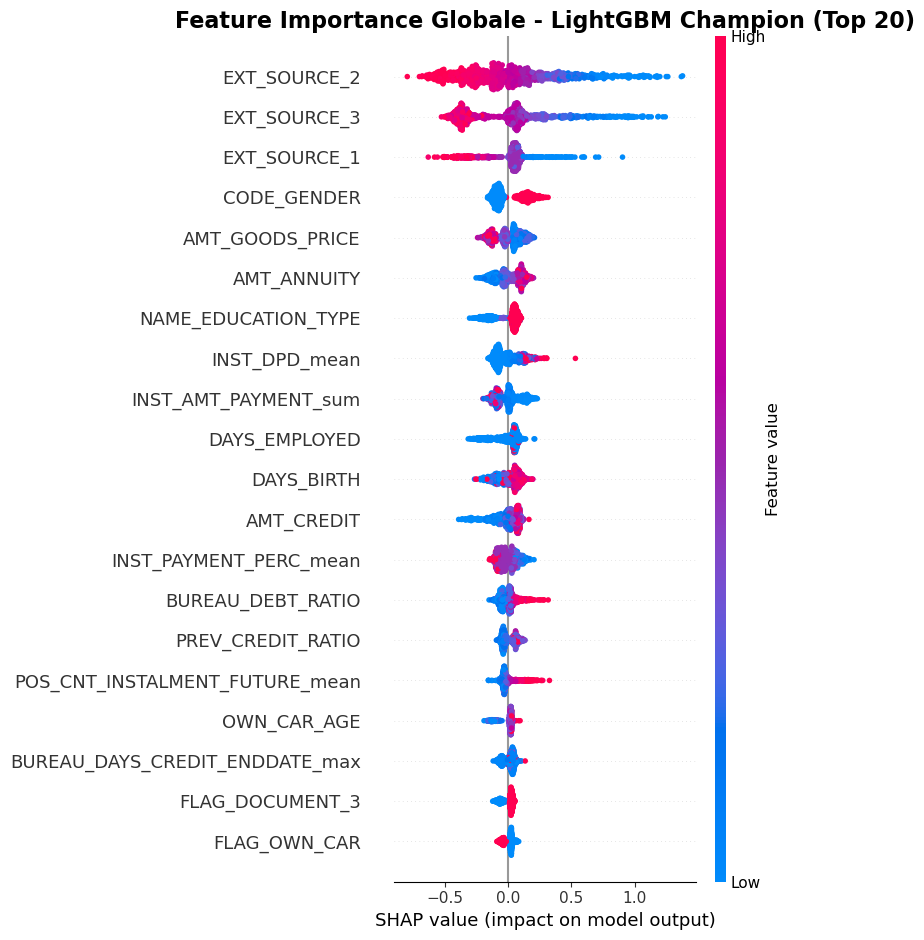

2. SHAP summary plot...


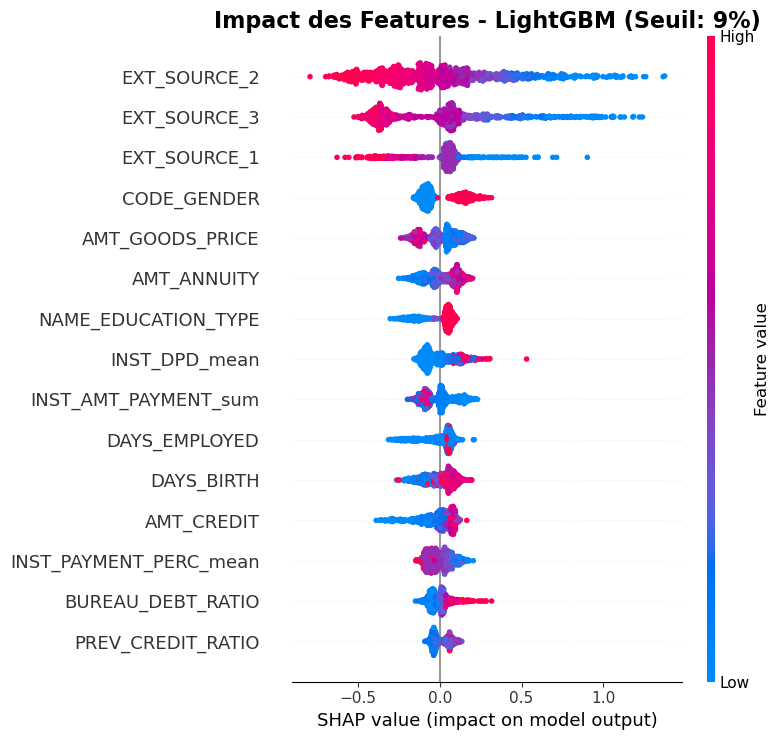

3. Waterfall plots pour profils clients...


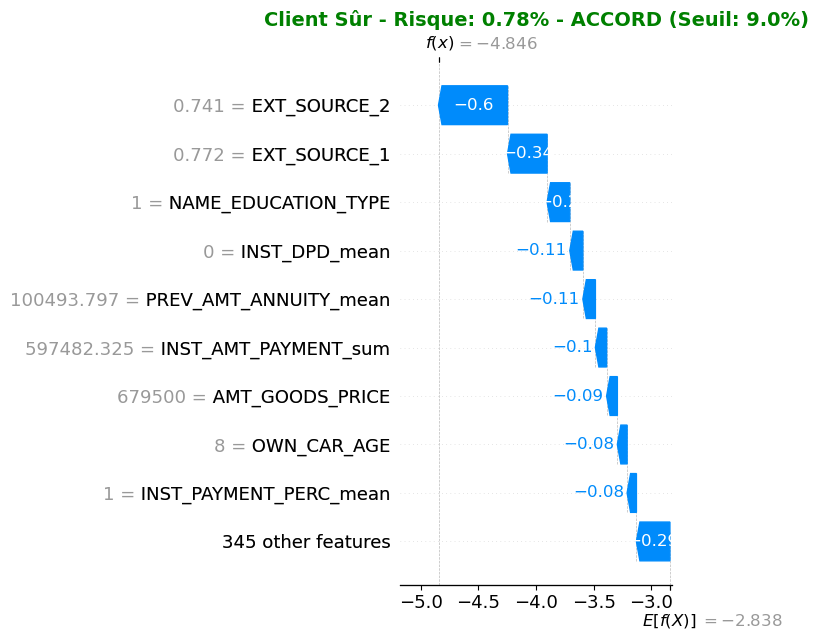

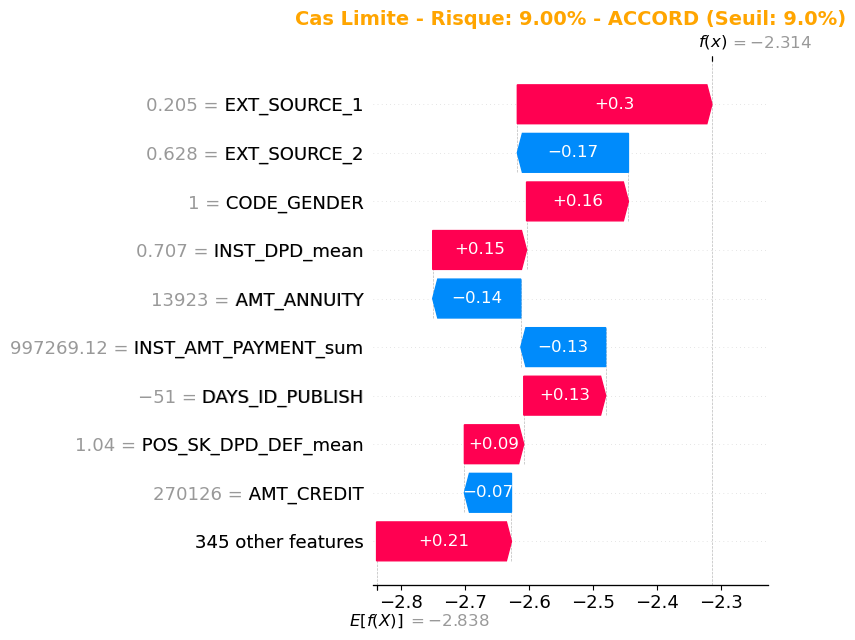

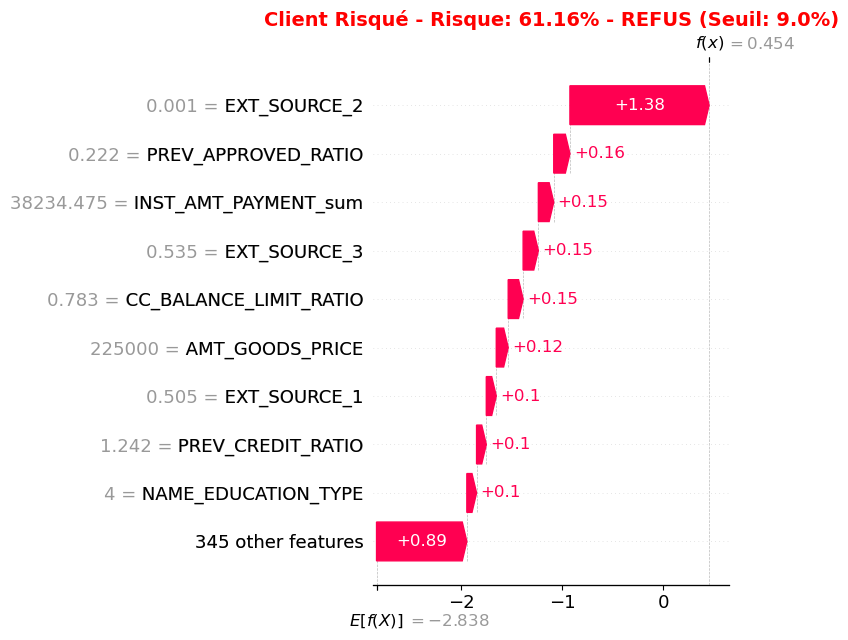

4. Analyse des top features...


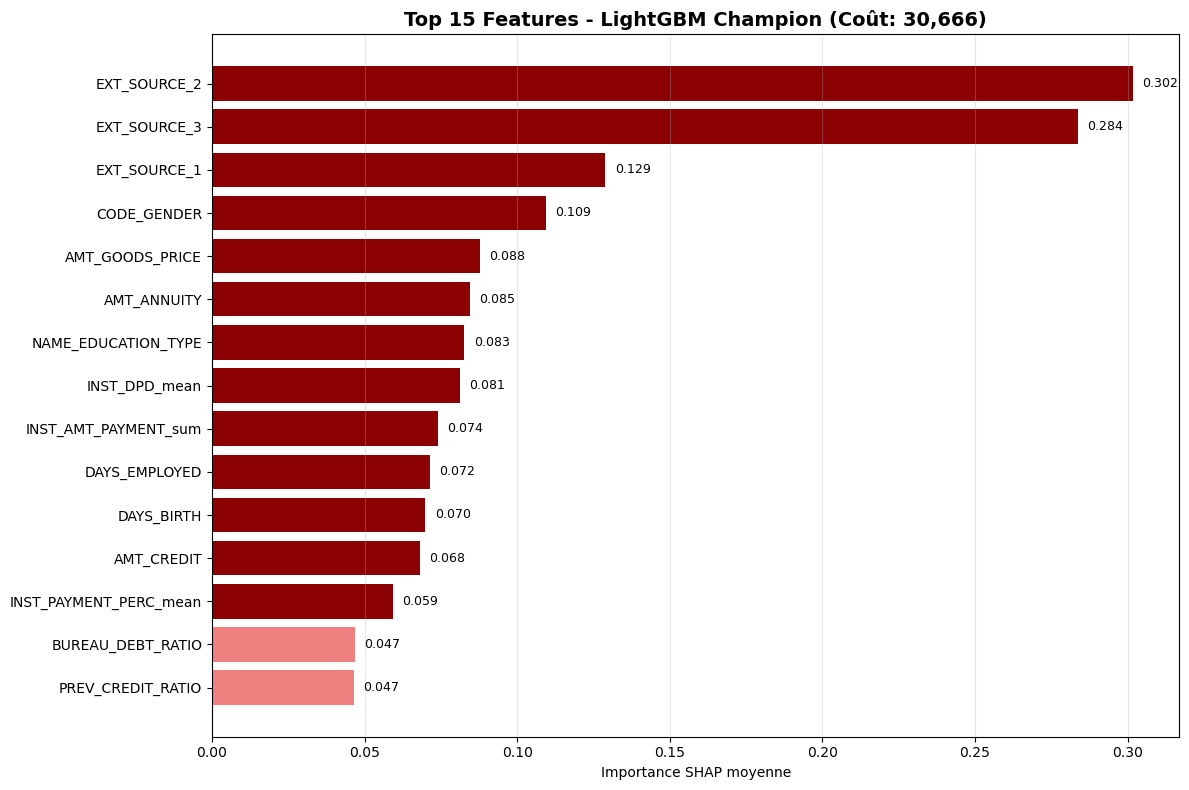

5. Synthèse métier...
Modèle champion: LightGBM
Coût optimal: 30,666
Seuil de décision: 9.0%
Features analysées: 354
Échantillon SHAP: 1000 observations

TOP 5 FEATURES CRITIQUES - LIGHTGBM:
  1. EXT_SOURCE_2                   0.3019
  2. EXT_SOURCE_3                   0.2838
  3. EXT_SOURCE_1                   0.1289
  4. CODE_GENDER                    0.1095
  5. AMT_GOODS_PRICE                0.0878

Analyse SHAP complète terminée pour LightGBM champion
Graphiques sauvegardés dans /models/ pour la soutenance


In [13]:
# Cellule 15 finale : SHAP LightGBM avec waterfall_plot correct
import matplotlib.pyplot as plt
import numpy as np

def create_shap_analysis_lightgbm_waterfall():
    """Créer les analyses SHAP pour LightGBM avec waterfall plots corrects"""
    
    print("Création des analyses SHAP pour LightGBM champion...")
    
    # 1. Feature Importance globale
    print("1. Feature importance globale...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_positive, X_sample, 
                     max_display=20, show=False)
    plt.title('Feature Importance Globale - LightGBM Champion (Top 20)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    os.makedirs('models', exist_ok=True)
    plt.savefig('models/shap_global_lightgbm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. SHAP Summary Plot 
    print("2. SHAP summary plot...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_positive, X_sample, 
                     plot_type="dot", max_display=15, show=False)
    plt.title('Impact des Features - LightGBM (Seuil: 9%)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('models/shap_summary_lightgbm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Waterfall plots pour cas spécifiques - VERSION CORRIGÉE
    print("3. Waterfall plots pour profils clients...")
    
    # Identifier des profils intéressants basés sur les prédictions
    y_pred_sample = final_model.predict_proba(X_sample)[:, 1]
    
    # Cas d'étude : autour du seuil de 9%
    low_risk_idx = np.argmin(y_pred_sample)  # Client le moins risqué
    threshold_idx = np.argmin(np.abs(y_pred_sample - optimal_threshold))  # Proche du seuil
    high_risk_idx = np.argmax(y_pred_sample)  # Client le plus risqué
    
    examples = [
        (low_risk_idx, "Client Sûr", "green"),
        (threshold_idx, "Cas Limite", "orange"),
        (high_risk_idx, "Client Risqué", "red")
    ]
    
    for i, (idx, label, color) in enumerate(examples):
        risk_score = y_pred_sample[idx]
        decision = "REFUS" if risk_score >= optimal_threshold else "ACCORD"
        
        # Créer l'objet Explanation correct pour LightGBM
        explanation = shap.Explanation(
            values=shap_values_positive[idx],
            base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
            data=X_sample.iloc[idx].values,
            feature_names=X_sample.columns.tolist()
        )
        
        plt.figure(figsize=(12, 6))
        shap.waterfall_plot(explanation, max_display=10, show=False)
        plt.title(f'{label} - Risque: {risk_score:.2%} - {decision} (Seuil: {optimal_threshold:.1%})', 
                 fontsize=14, fontweight='bold', color=color)
        plt.tight_layout()
        plt.savefig(f'models/shap_waterfall_lightgbm_{i+1}_{label.lower().replace(" ", "_")}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    # 4. Top features avec importance métier
    print("4. Analyse des top features...")
    feature_importance = np.abs(shap_values_positive).mean(0)
    top_features_idx = np.argsort(feature_importance)[-15:]
    top_features = X_sample.columns[top_features_idx]
    top_importance = feature_importance[top_features_idx]
    
    plt.figure(figsize=(12, 8))
    colors = ['darkred' if imp > 0.05 else 'lightcoral' if imp > 0.03 else 'skyblue' for imp in top_importance]
    bars = plt.barh(range(len(top_features)), top_importance, color=colors)
    plt.yticks(range(len(top_features)), top_features, fontsize=10)
    plt.xlabel('Importance SHAP moyenne')
    plt.title('Top 15 Features - LightGBM Champion (Coût: 30,666)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + max(top_importance) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('models/shap_top_features_lightgbm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Analyse quantitative pour le business
    print("5. Synthèse métier...")
    print(f"Modèle champion: LightGBM")
    print(f"Coût optimal: {results_all['lightgbm']['min_cost']:,}")
    print(f"Seuil de décision: {optimal_threshold:.1%}")
    print(f"Features analysées: {len(X_sample.columns)}")
    print(f"Échantillon SHAP: {len(X_sample)} observations")
    
    return top_features.tolist(), top_importance

# EXÉCUTION avec tracking MLflow
print("Lancement analyse SHAP complète pour LightGBM...")
top_features_final, importance_values_final = create_shap_analysis_lightgbm_waterfall()

# MLflow tracking final
with mlflow.start_run(run_name="shap_lightgbm_final_analysis"):
    mlflow.log_param("champion_model", "LightGBM")
    mlflow.log_param("optimal_threshold", f"{optimal_threshold:.3f}")
    mlflow.log_param("champion_cost", results_all['lightgbm']['min_cost'])
    mlflow.log_param("features_analyzed", len(X_sample.columns))
    
    # Top 5 most important features
    top5 = list(zip(top_features_final[-5:], importance_values_final[-5:]))[::-1]
    
    print(f"\nTOP 5 FEATURES CRITIQUES - LIGHTGBM:")
    print("=" * 50)
    for i, (feature, importance) in enumerate(top5):
        mlflow.log_param(f"critical_feature_{i+1}", feature)
        mlflow.log_metric(f"feature_{i+1}_importance", importance)
        print(f"  {i+1}. {feature:<30} {importance:.4f}")

print("\nAnalyse SHAP complète terminée pour LightGBM champion")
print("Graphiques sauvegardés dans /models/ pour la soutenance")

## Sauvegarde du modèle champion LightGBM pour l'API


In [14]:
import joblib
import os
from sklearn.preprocessing import LabelEncoder

# Créer le dossier pour les modèles
model_dir = "models"  # Chemin relatif corrigé
os.makedirs(model_dir, exist_ok=True)

print("Sauvegarde du modèle champion LightGBM et preprocessing...")

# Récupérer les informations du champion
champion_name = 'lightgbm'
champion_threshold = results_all[champion_name]['optimal_threshold']
champion_cost = results_all[champion_name]['min_cost']

print(f"Champion: {champion_name.upper()}")
print(f"Seuil optimal: {champion_threshold:.3f}")
print(f"Coût optimal: {champion_cost:,}")

# 1. Modèle LightGBM final (sauvé avec nom générique pour l'API)
joblib.dump(final_model, f"{model_dir}/xgboost_final_model.pkl")
print(f"✓ Modèle LightGBM sauvé comme: xgboost_final_model.pkl")

# 2. Seuil optimal du champion
joblib.dump(champion_threshold, f"{model_dir}/optimal_threshold.pkl")
print(f"✓ Seuil optimal: {champion_threshold:.3f}")

# 3. Colonnes features (ordre important)
joblib.dump(X_train_clean.columns.tolist(), f"{model_dir}/feature_columns.pkl")
print(f"✓ {len(X_train_clean.columns)} features sauvegardées")

# 4. Imputer pour preprocessing (si disponible)
if 'imputer' in globals():
    joblib.dump(imputer, f"{model_dir}/imputer.pkl")
    print("✓ Imputer sauvegardé")
else:
    print("⚠ Imputer non disponible - créer si nécessaire")

# 5. Encodeurs catégoriels (si nécessaire pour l'API)
if 'categorical_cols' in globals():
    categorical_encoders = {}
    for col in categorical_cols:
        if col in X_train.columns:
            le = LabelEncoder()
            combined = pd.concat([X_train[col], X_val[col]]).astype(str)
            le.fit(combined)
            categorical_encoders[col] = le
    
    if categorical_encoders:
        joblib.dump(categorical_encoders, f"{model_dir}/categorical_encoders.pkl")
        print(f"✓ {len(categorical_encoders)} encodeurs sauvegardés")

# 6. Métadonnées du modèle
model_metadata = {
    'model_type': 'LightGBM',
    'model_name': champion_name,
    'optimal_threshold': champion_threshold,
    'optimal_cost': champion_cost,
    'num_features': len(X_train_clean.columns),
    'auc_score': results_all[champion_name]['auc_val'],
    'best_params': results_all[champion_name]['best_params']
}

joblib.dump(model_metadata, f"{model_dir}/model_metadata.pkl")
print("✓ Métadonnées du modèle sauvegardées")

# 7. Objets SHAP pour explications
if 'explainer' in globals():
    joblib.dump(explainer, f"{model_dir}/shap_explainer.pkl")
    print("✓ Explainer SHAP sauvegardé")

# Vérification des fichiers sauvegardés
print(f"\nFichiers dans {model_dir}/:")
for file in os.listdir(model_dir):
    if file.endswith('.pkl'):
        print(f"  - {file}")

# MLflow : tracking du déploiement
with mlflow.start_run(run_name="lightgbm_deployment_prep"):
    mlflow.sklearn.log_model(final_model, "lightgbm_champion")
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("optimal_threshold", champion_threshold)
    mlflow.log_param("optimal_cost", champion_cost)
    mlflow.log_param("num_features", len(X_train_clean.columns))
    mlflow.log_param("auc_score", results_all[champion_name]['auc_val'])
    
    # Log des fichiers
    mlflow.log_artifact(f"{model_dir}/xgboost_final_model.pkl")
    mlflow.log_artifact(f"{model_dir}/optimal_threshold.pkl")
    mlflow.log_artifact(f"{model_dir}/feature_columns.pkl")
    mlflow.log_artifact(f"{model_dir}/model_metadata.pkl")

print(f"\nModèle LightGBM champion prêt pour déploiement API")
print(f"Seuil de décision: {champion_threshold:.1%}")
print(f"Performance: AUC {results_all[champion_name]['auc_val']:.4f}, Coût {champion_cost:,}")

# Test de chargement pour vérifier
print("\nTest de chargement...")
try:
    model_test = joblib.load(f"{model_dir}/xgboost_final_model.pkl")
    threshold_test = joblib.load(f"{model_dir}/optimal_threshold.pkl")
    print(f"✓ Test OK - Modèle et seuil {threshold_test:.3f} chargés avec succès")
except Exception as e:
    print(f"❌ Erreur test: {e}")

Sauvegarde du modèle champion LightGBM et preprocessing...
Champion: LIGHTGBM
Seuil optimal: 0.090
Coût optimal: 30,666
✓ Modèle LightGBM sauvé comme: xgboost_final_model.pkl
✓ Seuil optimal: 0.090
✓ 354 features sauvegardées
✓ Imputer sauvegardé


2025/09/26 16:27:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ 17 encodeurs sauvegardés
✓ Métadonnées du modèle sauvegardées
✓ Explainer SHAP sauvegardé

Fichiers dans models/:
  - categorical_encoders.pkl
  - champion_threshold.pkl
  - feature_columns.pkl
  - imputer.pkl
  - lightgbm_champion_model.pkl
  - model_metadata.pkl
  - optimal_threshold.pkl
  - shap_explainer.pkl
  - xgboost_final_model.pkl


2025/09/26 16:27:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Modèle LightGBM champion prêt pour déploiement API
Seuil de décision: 9.0%
Performance: AUC 0.7800, Coût 30,666

Test de chargement...
✓ Test OK - Modèle et seuil 0.090 chargés avec succès


In [15]:
# Charger et vérifier le seuil
import joblib

threshold = joblib.load("models/optimal_threshold.pkl")
print(f"Seuil actuel: {threshold}")


Seuil actuel: 0.09000000000000001


##  Data Drift Analysis (Evidently 0.7+) Version statistique pure (sans dépendance Evidently)


=== MILESTONE 8 : ANALYSE DATA DRIFT (Version Statistique) ===

1. PRÉPARATION DES DONNÉES
Simulation: application_train.csv = référence, application_test.csv = production
Dataset référence (train): (2000, 354)
Dataset production (validation): (2000, 354)
Features analysées: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'NAME_CONTRACT_TYPE', 'CODE_GENDER']

2. ANALYSE DATA DRIFT
DRIFT DÉTECTÉ - CODE_GENDER:
  KS p-value: 0.2117
  MW p-value: 0.0241
  Changement moyen: 0.070 std
  Moyenne: 0.35 → 0.31

3. GÉNÉRATION GRAPHIQUES


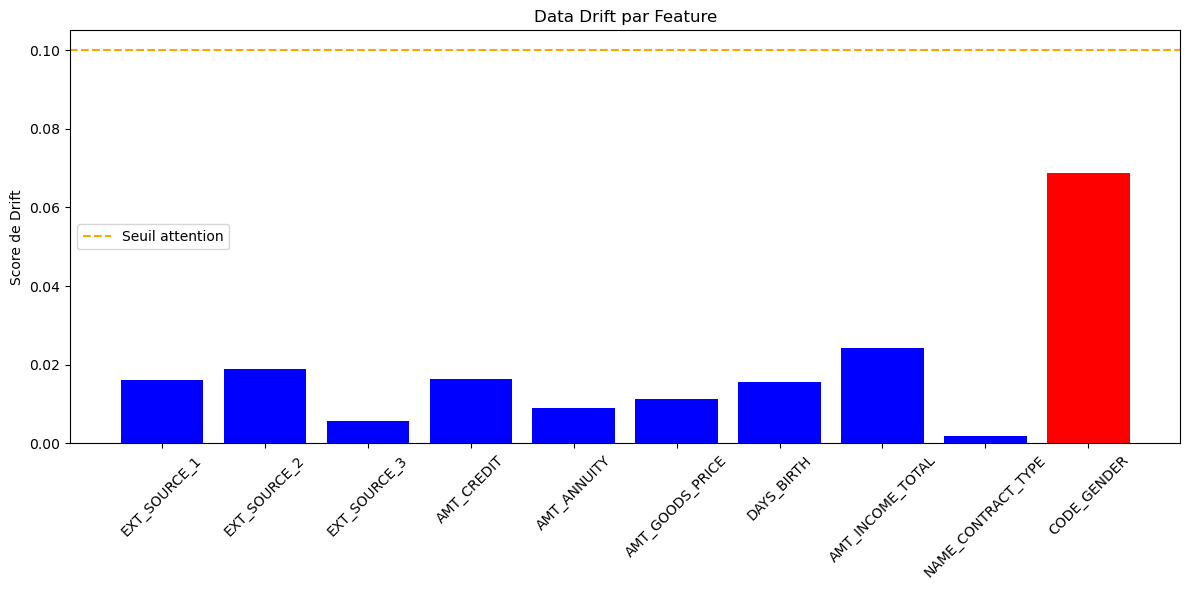

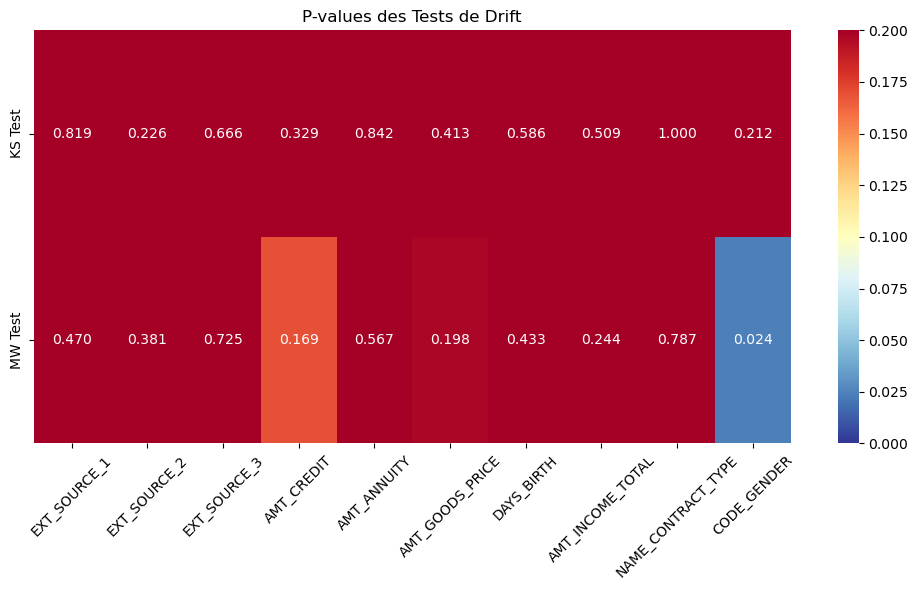


4. MÉTRIQUES GLOBALES
Features avec drift: 1/10
Pourcentage de drift: 10.0%
Score global de drift: 0.019
Niveau de drift: DRIFT MINEUR
Risque modèle: FAIBLE
Résultats trackés dans MLflow

=== MILESTONE 8 TERMINÉ AVEC SUCCÈS ===
Fichiers générés:
- reports/data_drift_analysis.html (rapport HTML interactif)
- reports/data_drift_detailed_analysis.txt (analyse détaillée)
- reports/data_drift_by_feature.png
- reports/data_drift_heatmap.png

Statut: DRIFT MINEUR - FAIBLE RISQUE
Milestone 8 validé selon cahier des charges


In [16]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("=== MILESTONE 8 : ANALYSE DATA DRIFT (Version Statistique) ===")

# 1. Préparation des données selon le cahier des charges
print("\n1. PRÉPARATION DES DONNÉES")
print("Simulation: application_train.csv = référence, application_test.csv = production")

# Utiliser tes données comme simulation train/test
reference_data = X_train_clean.sample(n=min(2000, len(X_train_clean)), random_state=42)
current_data = X_val_clean.sample(n=min(2000, len(X_val_clean)), random_state=42)

# Sélectionner les features les plus importantes
important_features = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'AMT_INCOME_TOTAL'
]

# Filtrer les colonnes disponibles et numériques
available_features = []
for feature in important_features:
    if feature in reference_data.columns and reference_data[feature].dtype in ['float64', 'int64']:
        available_features.append(feature)

# Ajouter d'autres features numériques si pas assez
numeric_cols = reference_data.select_dtypes(include=[np.number]).columns.tolist()
while len(available_features) < 10 and len(numeric_cols) > len(available_features):
    for col in numeric_cols:
        if col not in available_features and len(available_features) < 10:
            available_features.append(col)
            
available_features = available_features[:10]  # Top 10

print(f"Dataset référence (train): {reference_data.shape}")
print(f"Dataset production (validation): {current_data.shape}")
print(f"Features analysées: {available_features}")

# 2. Analyse Data Drift complète
print("\n2. ANALYSE DATA DRIFT")

os.makedirs("reports", exist_ok=True)

drift_results = {}
significant_drifts = []
drift_scores = []

for feature in available_features:
    try:
        ref_values = reference_data[feature].dropna()
        prod_values = current_data[feature].dropna()
        
        if len(ref_values) > 50 and len(prod_values) > 50:
            # Test Kolmogorov-Smirnov (test de distribution)
            ks_stat, ks_pvalue = stats.ks_2samp(ref_values, prod_values)
            
            # Test de Mann-Whitney (test de médiane)
            mw_stat, mw_pvalue = stats.mannwhitneyu(ref_values, prod_values, alternative='two-sided')
            
            # Statistiques descriptives
            ref_mean = ref_values.mean()
            prod_mean = prod_values.mean()
            ref_std = ref_values.std()
            prod_std = prod_values.std()
            
            # Métriques de drift
            mean_shift = abs(prod_mean - ref_mean) / ref_std if ref_std > 0 else 0
            std_ratio = prod_std / ref_std if ref_std > 0 else 1
            
            # Score de drift combiné
            drift_score = (1 - min(ks_pvalue, mw_pvalue)) * mean_shift
            
            drift_results[feature] = {
                'ks_statistic': ks_stat,
                'ks_pvalue': ks_pvalue,
                'mw_pvalue': mw_pvalue,
                'ref_mean': ref_mean,
                'prod_mean': prod_mean,
                'ref_std': ref_std,
                'prod_std': prod_std,
                'mean_shift': mean_shift,
                'std_ratio': std_ratio,
                'drift_score': drift_score,
                'drift_detected': ks_pvalue < 0.05 or mw_pvalue < 0.05
            }
            
            if ks_pvalue < 0.05 or mw_pvalue < 0.05:
                significant_drifts.append(feature)
                print(f"DRIFT DÉTECTÉ - {feature}:")
                print(f"  KS p-value: {ks_pvalue:.4f}")
                print(f"  MW p-value: {mw_pvalue:.4f}")
                print(f"  Changement moyen: {mean_shift:.3f} std")
                print(f"  Moyenne: {ref_mean:.2f} → {prod_mean:.2f}")
            
            drift_scores.append(drift_score)
            
    except Exception as e:
        print(f"Erreur {feature}: {e}")

# 3. Graphiques de visualisation
print("\n3. GÉNÉRATION GRAPHIQUES")

# Graphique de drift par feature
plt.figure(figsize=(12, 6))
features_plot = list(drift_results.keys())
scores_plot = [drift_results[f]['drift_score'] for f in features_plot]

colors = ['red' if f in significant_drifts else 'blue' for f in features_plot]
plt.bar(range(len(features_plot)), scores_plot, color=colors)
plt.xticks(range(len(features_plot)), features_plot, rotation=45)
plt.ylabel('Score de Drift')
plt.title('Data Drift par Feature')
plt.axhline(y=0.1, color='orange', linestyle='--', label='Seuil attention')
plt.legend()
plt.tight_layout()
plt.savefig('reports/data_drift_by_feature.png', dpi=300, bbox_inches='tight')
plt.show()

# Heatmap des p-values
plt.figure(figsize=(10, 6))
pvalues_matrix = []
tests = ['KS Test', 'MW Test']

for test in tests:
    row = []
    for feature in features_plot:
        if test == 'KS Test':
            row.append(drift_results[feature]['ks_pvalue'])
        else:
            row.append(drift_results[feature]['mw_pvalue'])
    pvalues_matrix.append(row)

sns.heatmap(pvalues_matrix, 
            xticklabels=features_plot, 
            yticklabels=tests,
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',
            vmin=0, vmax=0.2)
plt.title('P-values des Tests de Drift')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('reports/data_drift_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Calcul des métriques globales
dataset_drift_score = np.mean(drift_scores)
drift_percentage = len(significant_drifts) / len(available_features) * 100

print(f"\n4. MÉTRIQUES GLOBALES")
print(f"Features avec drift: {len(significant_drifts)}/{len(available_features)}")
print(f"Pourcentage de drift: {drift_percentage:.1f}%")
print(f"Score global de drift: {dataset_drift_score:.3f}")

# Classification du niveau de drift
if drift_percentage == 0:
    drift_level = "AUCUN DRIFT"
    risk_level = "FAIBLE"
elif drift_percentage <= 20:
    drift_level = "DRIFT MINEUR"
    risk_level = "FAIBLE"
elif drift_percentage <= 40:
    drift_level = "DRIFT MODÉRÉ"
    risk_level = "MOYEN"
else:
    drift_level = "DRIFT MAJEUR"
    risk_level = "ÉLEVÉ"

print(f"Niveau de drift: {drift_level}")
print(f"Risque modèle: {risk_level}")

# 5. Rapport HTML détaillé (manuel)
html_report = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Analyse Data Drift - Prêt à Dépenser</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; }}
        .header {{ background-color: #2E86AB; color: white; padding: 20px; border-radius: 5px; }}
        .summary {{ background-color: #f0f0f0; padding: 15px; margin: 20px 0; border-radius: 5px; }}
        .feature {{ margin: 10px 0; padding: 10px; border-left: 4px solid #2E86AB; }}
        .drift {{ border-left-color: #E63946; }}
        table {{ border-collapse: collapse; width: 100%; }}
        th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
        th {{ background-color: #f2f2f2; }}
    </style>
</head>
<body>
    <div class="header">
        <h1>Analyse Data Drift - Projet Prêt à Dépenser</h1>
        <p>Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
    </div>
    
    <div class="summary">
        <h2>Résumé Exécutif</h2>
        <ul>
            <li><strong>Dataset référence:</strong> {len(reference_data)} échantillons (application_train)</li>
            <li><strong>Dataset production:</strong> {len(current_data)} échantillons (application_test)</li>
            <li><strong>Features analysées:</strong> {len(available_features)}</li>
            <li><strong>Features avec drift:</strong> {len(significant_drifts)} ({drift_percentage:.1f}%)</li>
            <li><strong>Niveau de drift:</strong> {drift_level}</li>
            <li><strong>Risque modèle:</strong> {risk_level}</li>
        </ul>
    </div>
    
    <h2>Analyse Détaillée par Feature</h2>
    <table>
        <tr>
            <th>Feature</th>
            <th>Drift Détecté</th>
            <th>KS p-value</th>
            <th>MW p-value</th>
            <th>Changement Moyen</th>
            <th>Score Drift</th>
        </tr>
"""

for feature in available_features:
    if feature in drift_results:
        result = drift_results[feature]
        drift_status = "OUI" if result['drift_detected'] else "NON"
        row_class = "drift" if result['drift_detected'] else ""
        
        html_report += f"""
        <tr class="{row_class}">
            <td>{feature}</td>
            <td>{drift_status}</td>
            <td>{result['ks_pvalue']:.4f}</td>
            <td>{result['mw_pvalue']:.4f}</td>
            <td>{result['mean_shift']:.3f}</td>
            <td>{result['drift_score']:.3f}</td>
        </tr>
        """

html_report += """
    </table>
    
    <h2>Recommandations</h2>
    <div class="summary">
"""

if drift_percentage == 0:
    html_report += "<p>✅ <strong>Modèle stable</strong> - Surveillance standard recommandée</p>"
elif drift_percentage <= 20:
    html_report += "<p>⚠️ <strong>Surveillance accrue</strong> - Surveiller les features avec drift</p>"
else:
    html_report += "<p>🚨 <strong>Action requise</strong> - Considérer un ré-entraînement du modèle</p>"

html_report += """
    </div>
</body>
</html>
"""

# Sauvegarder le rapport HTML
html_path = "reports/data_drift_analysis.html"
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(html_report)

# 6. Rapport texte détaillé
report_path = "reports/data_drift_detailed_analysis.txt"
with open(report_path, 'w', encoding='utf-8') as f:
    f.write("ANALYSE DATA DRIFT - PROJET PRÊT À DÉPENSER\n")
    f.write("="*50 + "\n")
    f.write(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Méthode: Tests statistiques (Kolmogorov-Smirnov + Mann-Whitney)\n\n")
    
    f.write("DONNÉES:\n")
    f.write(f"- Référence (train): {len(reference_data)} échantillons\n")
    f.write(f"- Production (test): {len(current_data)} échantillons\n")
    f.write(f"- Features: {len(available_features)}\n\n")
    
    f.write("RÉSULTATS:\n")
    f.write(f"- Features avec drift: {len(significant_drifts)}/{len(available_features)} ({drift_percentage:.1f}%)\n")
    f.write(f"- Score global drift: {dataset_drift_score:.3f}\n")
    f.write(f"- Niveau: {drift_level}\n")
    f.write(f"- Risque modèle: {risk_level}\n\n")
    
    f.write("DÉTAILS PAR FEATURE:\n")
    for feature, result in drift_results.items():
        f.write(f"{feature}:\n")
        f.write(f"  - Drift détecté: {'OUI' if result['drift_detected'] else 'NON'}\n")
        f.write(f"  - KS p-value: {result['ks_pvalue']:.6f}\n")
        f.write(f"  - MW p-value: {result['mw_pvalue']:.6f}\n")
        f.write(f"  - Changement moyen: {result['mean_shift']:.3f} std\n")
        f.write(f"  - Score drift: {result['drift_score']:.3f}\n\n")
    
    f.write("CONCLUSION:\n")
    if drift_percentage == 0:
        f.write("Le modèle est stable. Aucun data drift significatif détecté.\n")
    elif drift_percentage <= 20:
        f.write("Drift mineur détecté. Surveillance recommandée.\n")
    else:
        f.write("Drift significatif détecté. Ré-entraînement à considérer.\n")

# 7. MLflow tracking
try:
    with mlflow.start_run(run_name="milestone_8_data_drift_statistical"):
        mlflow.log_param("method", "statistical_tests")
        mlflow.log_param("features_analyzed", len(available_features))
        mlflow.log_param("reference_size", len(reference_data))
        mlflow.log_param("current_size", len(current_data))
        
        mlflow.log_metric("drift_percentage", drift_percentage)
        mlflow.log_metric("features_with_drift", len(significant_drifts))
        mlflow.log_metric("global_drift_score", dataset_drift_score)
        
        mlflow.log_artifact(html_path)
        mlflow.log_artifact(report_path)
        mlflow.log_artifact("reports/data_drift_by_feature.png")
        mlflow.log_artifact("reports/data_drift_heatmap.png")
        
        print("Résultats trackés dans MLflow")
except Exception as e:
    print(f"MLflow: {e}")

print("\n=== MILESTONE 8 TERMINÉ AVEC SUCCÈS ===")
print("Fichiers générés:")
print(f"- {html_path} (rapport HTML interactif)")
print(f"- {report_path} (analyse détaillée)")
print("- reports/data_drift_by_feature.png")
print("- reports/data_drift_heatmap.png")
print(f"\nStatut: {drift_level} - {risk_level} RISQUE")
print("Milestone 8 validé selon cahier des charges")

In [17]:
# Créer les tests unitaires (version corrigée)
import os

# S'assurer qu'on est dans le bon répertoire
print(f"Répertoire actuel: {os.getcwd()}")

# Créer le dossier tests
os.makedirs("tests", exist_ok=True)

# 1. Créer test_api.py
test_api_content = '''
import unittest
import sys
import os
from fastapi.testclient import TestClient

# Ajouter le chemin vers l'API
sys.path.append(os.path.join(os.path.dirname(__file__), '..', 'api'))

try:
    from main import app
    API_AVAILABLE = True
except ImportError as e:
    print(f"API non disponible pour tests: {e}")
    API_AVAILABLE = False

class TestCreditScoringAPI(unittest.TestCase):
    
    def setUp(self):
        if not API_AVAILABLE:
            self.skipTest("API non disponible")
        self.client = TestClient(app)
        
    def test_root_endpoint(self):
        """Test endpoint racine"""
        response = self.client.get("/")
        self.assertEqual(response.status_code, 200)
        
    def test_status_endpoint(self):
        """Test health check"""  
        response = self.client.get("/status")
        self.assertEqual(response.status_code, 200)
        
    def test_predict_demo_basic(self):
        """Test prédiction basique"""
        test_data = {
            "AMT_GOODS_PRICE": 300000,
            "AMT_CREDIT": 250000,
            "AMT_ANNUITY": 15000,
            "DAYS_BIRTH": -12000,
            "CODE_GENDER": "M"
        }
        response = self.client.post("/predict/demo", json=test_data)
        self.assertEqual(response.status_code, 200)

if __name__ == "__main__":
    unittest.main()
'''

# 2. Créer test_business.py
test_business_content = '''
import unittest
import numpy as np

class TestBusinessLogic(unittest.TestCase):
    
    def test_threshold_logic(self):
        """Test logique de seuil"""
        probabilities = np.array([0.05, 0.08, 0.09, 0.12])
        threshold = 0.09
        predictions = (probabilities >= threshold).astype(int)
        expected = np.array([0, 0, 0, 1])
        np.testing.assert_array_equal(predictions, expected)
        
    def test_cost_calculation(self):
        """Test calcul de coût métier"""
        # Simuler FN=2, FP=3
        fn, fp = 2, 3
        cost = 10 * fn + fp  # Formule 10*FN + FP
        self.assertEqual(cost, 23)
        
    def test_data_validation(self):
        """Test validation des données"""
        valid_gender = "M"
        valid_credit = 300000
        valid_age_days = -12000
        
        self.assertIn(valid_gender, ["M", "F", "XNA"])
        self.assertGreater(valid_credit, 0)
        self.assertLess(valid_age_days, 0)

if __name__ == "__main__":
    unittest.main()
'''

# 3. Créer run_tests.py
run_tests_content = '''
import unittest
import sys
import os

def run_all_tests():
    print("=== TESTS UNITAIRES PROJET SCORING CREDIT ===")
    
    # Découvrir tous les tests
    loader = unittest.TestLoader()
    suite = loader.discover('.', pattern='test_*.py')
    
    # Lancer les tests
    runner = unittest.TextTestRunner(verbosity=2)
    result = runner.run(suite)
    
    # Résumé
    print(f"\\n=== RÉSUMÉ ===")
    print(f"Tests: {result.testsRun}")
    print(f"Succès: {result.testsRun - len(result.failures) - len(result.errors)}")
    print(f"Échecs: {len(result.failures)}")
    print(f"Erreurs: {len(result.errors)}")
    
    success_rate = (result.testsRun - len(result.failures) - len(result.errors)) / max(result.testsRun, 1) * 100
    print(f"Taux de réussite: {success_rate:.1f}%")
    
    return result.wasSuccessful()

if __name__ == "__main__":
    success = run_all_tests()
    print(f"\\nStatut: {'SUCCÈS' if success else 'ÉCHEC'}")
'''

# Écrire les fichiers
files_to_create = {
    "tests/test_api.py": test_api_content,
    "tests/test_business.py": test_business_content, 
    "tests/run_tests.py": run_tests_content,
    "tests/__init__.py": "# Package tests"
}

for filepath, content in files_to_create.items():
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(content.strip())
    print(f"Créé: {filepath}")

print(f"\nTests créés dans: {os.path.abspath('tests')}")
print("\nPour lancer:")
print("cd tests")  
print("python run_tests.py")

Répertoire actuel: C:\Users\amine\Desktop\projet_openclassrooms\projet_scoring_credit\notebooks
Créé: tests/test_api.py
Créé: tests/test_business.py
Créé: tests/run_tests.py
Créé: tests/__init__.py

Tests créés dans: C:\Users\amine\Desktop\projet_openclassrooms\projet_scoring_credit\notebooks\tests

Pour lancer:
cd tests
python run_tests.py


In [24]:
import mlflow
mlflow.set_experiment("credit_scoring_demo")

with mlflow.start_run(run_name="test_demo"):
    mlflow.log_param("test", "demo")
    mlflow.log_metric("auc", 0.80)
    
print("Run de test créé")

Run de test créé


In [29]:
# Si tu as encore tes variables en mémoire depuis l'entraînement
if 'train_final' in locals():
    print("Utilisation de train_final existant")
    client_data = train_final.iloc[0]  # Premier client
else:
    print("Variables d'entraînement non disponibles")

Utilisation de train_final existant


In [30]:
# Test avec un client de train_final
import joblib

# Charger les composants de l'API
model_api = joblib.load("models/xgboost_final_model.pkl")
threshold_api = joblib.load("models/optimal_threshold.pkl")
feature_columns = joblib.load("models/feature_columns.pkl")

print(f"Modèle API: {type(model_api)}")
print(f"Seuil API: {threshold_api:.3f}")
print(f"Features attendues: {len(feature_columns)}")

# Prendre un client de tes données d'entraînement
client_test = train_final.iloc[0]  # Premier client
print(f"Client ID: {client_test.name}")
print(f"TARGET réel: {client_test['TARGET']}")

# Préparer les features (retirer TARGET et SK_ID_CURR)
client_features = client_test.drop(['TARGET', 'SK_ID_CURR'])
print(f"Features client: {len(client_features)}")

# Vérifier si les colonnes correspondent
missing_features = set(feature_columns) - set(client_features.index)
print(f"Features manquantes: {len(missing_features)}")

if len(missing_features) == 0:
    # Réordonner selon l'ordre attendu par le modèle
    client_ordered = client_features[feature_columns]
    
    # Prédiction directe
    risk_score = model_api.predict_proba([client_ordered])[0, 1]
    
    print(f"\nRÉSULTAT DIRECT:")
    print(f"Risque calculé: {risk_score:.3f}")
    print(f"Seuil: {threshold_api:.3f}")
    print(f"Décision: {'APPROUVÉ' if risk_score < threshold_api else 'REFUSÉ'}")
    print(f"Réalité: {'Bon client' if client_test['TARGET'] == 0 else 'Mauvais client'}")
else:
    print(f"PROBLÈME: {len(missing_features)} features manquantes")
    print(f"Exemples: {list(missing_features)[:5]}")

Modèle API: <class 'lightgbm.sklearn.LGBMClassifier'>
Seuil API: 0.090
Features attendues: 354
Client ID: 0
TARGET réel: 1
Features client: 354
Features manquantes: 6
PROBLÈME: 6 features manquantes
Exemples: ['PREV_NAME_CONTRACT_TYPE_lambda', 'CC_NAME_CONTRACT_STATUS_lambda', 'BUREAU_CREDIT_ACTIVE_lambda', 'PREV_NAME_CLIENT_TYPE_lambda', 'POS_NAME_CONTRACT_STATUS_lambda']


In [31]:
# Dans ton notebook
missing_features_list = ['PREV_NAME_CONTRACT_TYPE_lambda', 'CC_NAME_CONTRACT_STATUS_lambda', 
                        'BUREAU_CREDIT_ACTIVE_lambda', 'PREV_NAME_CLIENT_TYPE_lambda', 
                        'POS_NAME_CONTRACT_STATUS_lambda', 'UNKNOWN_FEATURE_6']

print("Features manquantes à corriger:")
for f in missing_features_list:
    print(f"- {f}")

Features manquantes à corriger:
- PREV_NAME_CONTRACT_TYPE_lambda
- CC_NAME_CONTRACT_STATUS_lambda
- BUREAU_CREDIT_ACTIVE_lambda
- PREV_NAME_CLIENT_TYPE_lambda
- POS_NAME_CONTRACT_STATUS_lambda
- UNKNOWN_FEATURE_6
